In [359]:
import matplotlib.pyplot as plt
import numpy
import pandas
import statsmodels.formula.api as smf
import statsmodels.api as sm
import thinkstats2
import thinkplot
import numpy as np
from sklearn import linear_model
from sklearn import feature_selection as fs
plt.figure(figsize=(30,15))
plt.rcParams["figure.figsize"] = (30,15)

<Figure size 2160x1080 with 0 Axes>

In [337]:
## Load CSV files to data frame for merging
salesorderdetail_df = pandas.read_csv("SalesOrderDetail.csv")

salesorderheader_df = pandas.read_csv("SalesOrderHeader.csv")

salesterritory_df = pandas.read_csv("SalesTerritory.csv")

specialoffer_df = pandas.read_csv("SpecialOffer.csv")

productdetails_df = pandas.read_csv("ProductDetails.csv")

productcategory_df = pandas.read_csv("ProductCategory.csv")

productsubcategory_df = pandas.read_csv("ProductSubcategory.csv")

In [338]:
## Parse down to necessary data using select function
salesorderdetail_df = salesorderdetail_df[["SalesOrderID", "OrderQty",  "ProductID", "SpecialOfferID", "UnitPrice", "LineTotal"]]

salesorderheader_df = salesorderheader_df[["TerritoryID", "SalesOrderID", "OrderDate", 'SalesPersonID', 'TotalDue']]

salesterritory_df = salesterritory_df[["Name", "CountryRegionCode", "Group", "TerritoryID"]]

specialoffer_df = specialoffer_df[["SpecialOfferID", "Description", "Type", "Category", "MinQty", "MaxQty", "DiscountPct"]]

productdetails_df = productdetails_df[["ProductID", "Name", "ProductNumber", "Color", "StandardCost", "ListPrice", "ProductSubcategoryID", "SafetyStockLevel", "ReorderPoint"]]

productcategory_df = productcategory_df[["ProductCategoryID", "Name"]]

productsubcategory_df = productsubcategory_df[["ProductSubcategoryID", "Name", "ProductCategoryID"]]

In [339]:
## Combine Product Data Frames, rename columns appropriately
## Left join product_subcategory_df to product_details_df on ProductSubcategoryID
## Left join product_category_df to newly merged product_details_df on 'new' ProductCategoryID column
product_merged_df = productdetails_df.merge(productsubcategory_df, how = "left", left_on = "ProductSubcategoryID", right_on = "ProductSubcategoryID").merge(
    productcategory_df, how = "left", left_on = "ProductCategoryID", right_on = "ProductCategoryID").rename(
    columns = {"Name_x" : "ProductName", "Name_y" : "Subcategory", "Name" : "Category"})

## Combine sales data frames and product_merged_df for final data frame, rename columns appropriately
## Left join product_merged_df from above to salesorderdetail_df on ProductID
## Left join salesorderheader_df on SalesOrderID
## Left join specialoffer_Df on SpecialOfferID
## Left join salesterritory_df on TerritoryID
final_merged_df = salesorderdetail_df.merge(product_merged_df, how = "left", left_on = "ProductID", right_on = "ProductID").merge(
    salesorderheader_df, how = "left", left_on = "SalesOrderID", right_on = "SalesOrderID").merge(
    specialoffer_df, how = "left", left_on = "SpecialOfferID", right_on = "SpecialOfferID").merge(
    salesterritory_df, how = "left", left_on = "TerritoryID", right_on = "TerritoryID").rename(
    columns = {"Category_x" : "Category", "Description" : "DiscountDescription", "Type" : "DiscountType",
               "Category_y" : "DiscountCategory", "Name" : "TerritoryName", "Group" : "TerritoryGroup"})

## Add year and month columns
final_merged_df['year'] = pandas.DatetimeIndex(final_merged_df['OrderDate']).year
final_merged_df['month'] = pandas.DatetimeIndex(final_merged_df['OrderDate']).month
final_merged_df['month_date'] = pandas.to_datetime(final_merged_df['OrderDate']).apply(lambda x: x.strftime('%Y-%m'))

specialoffer_df['DiscountPct'] = specialoffer_df['DiscountPct'] * 100

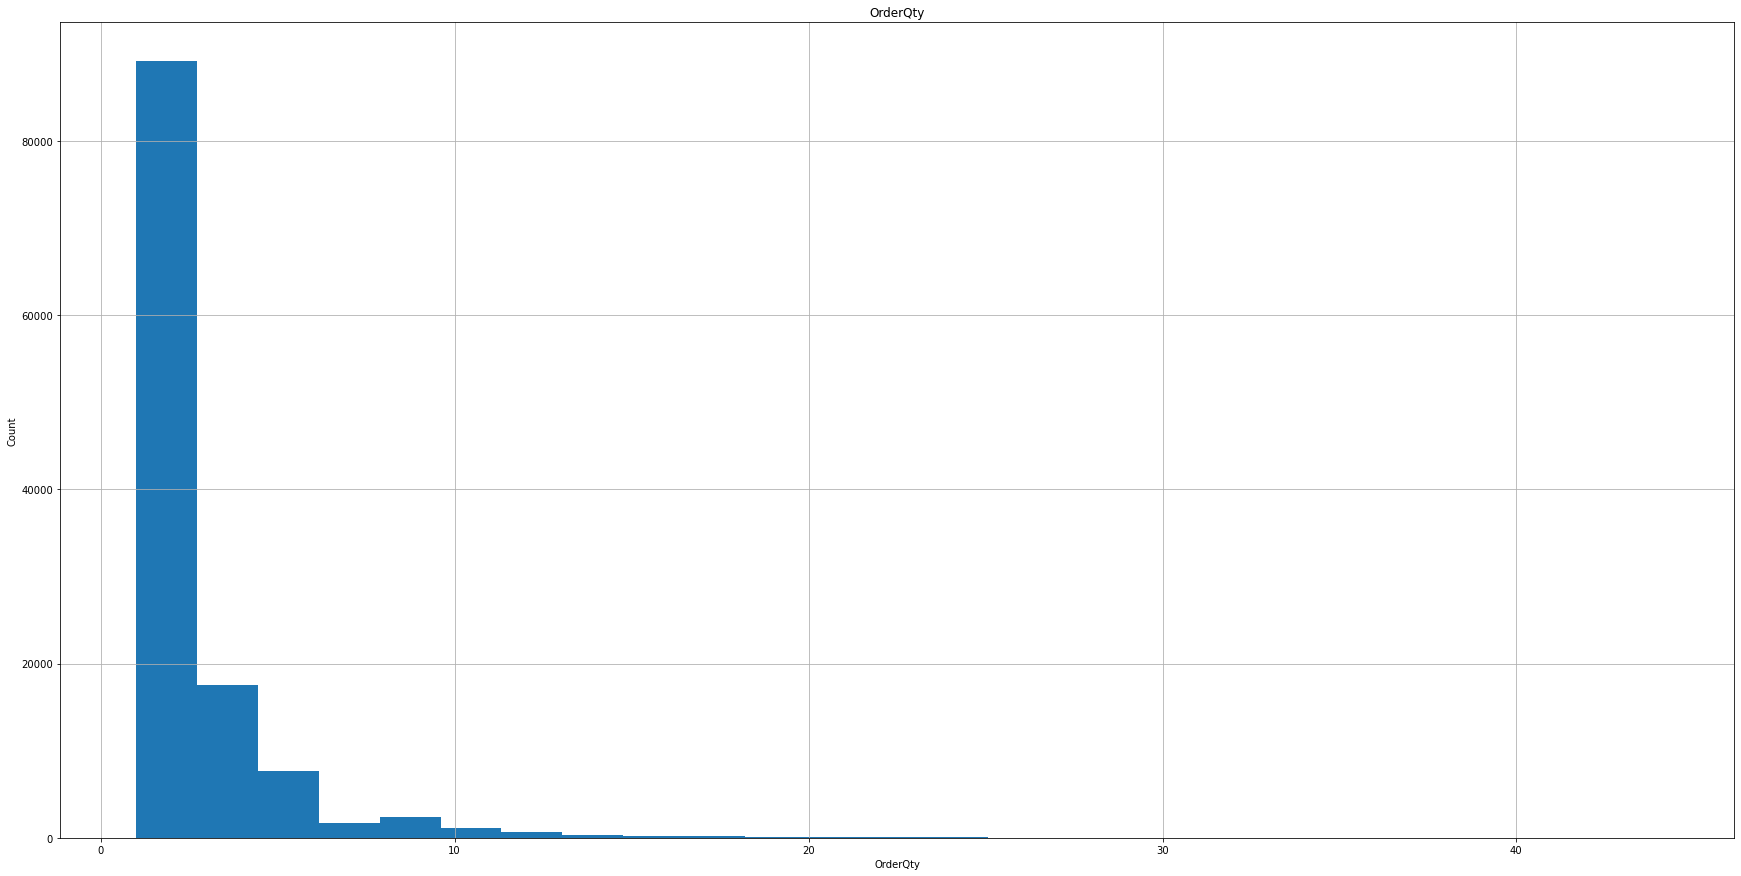

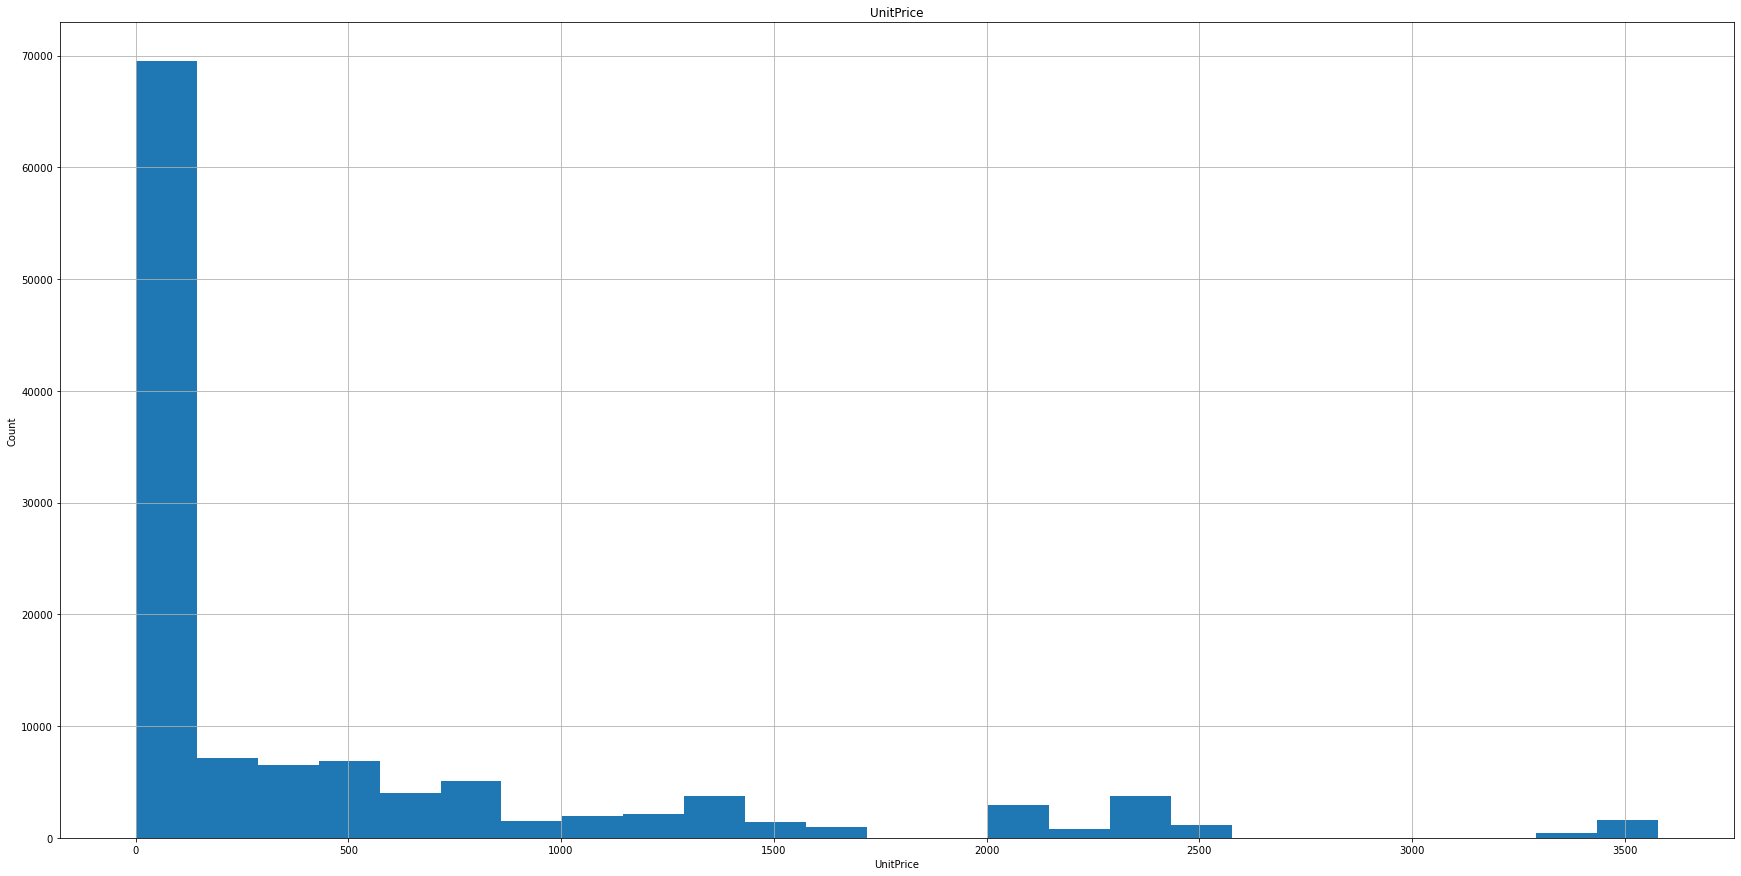

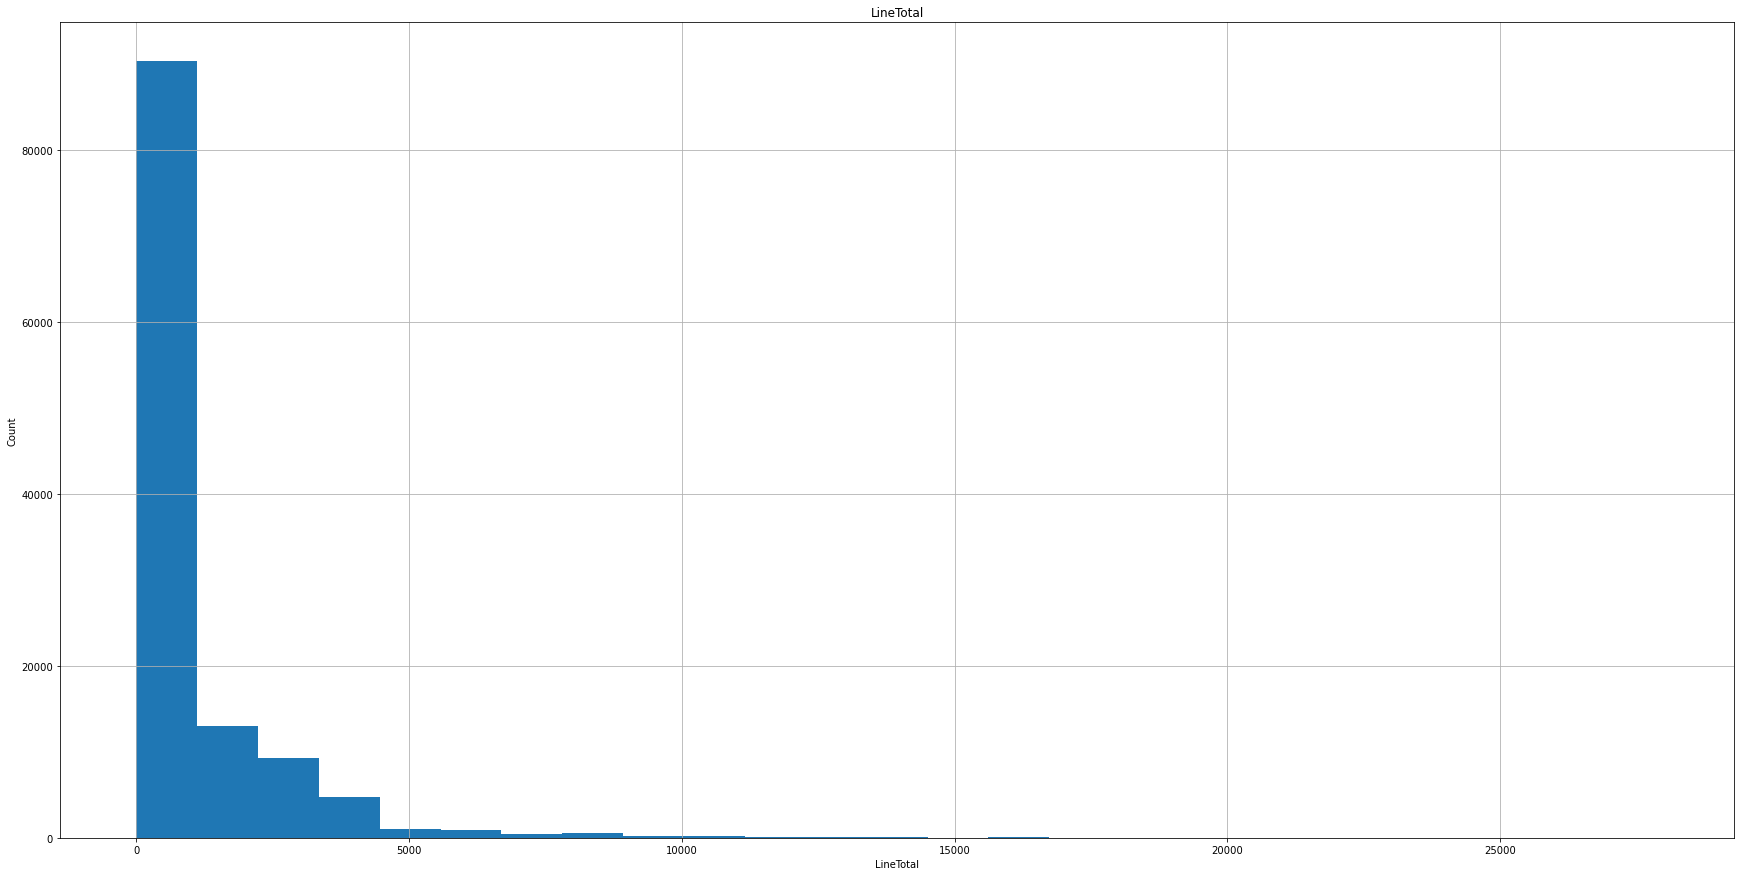

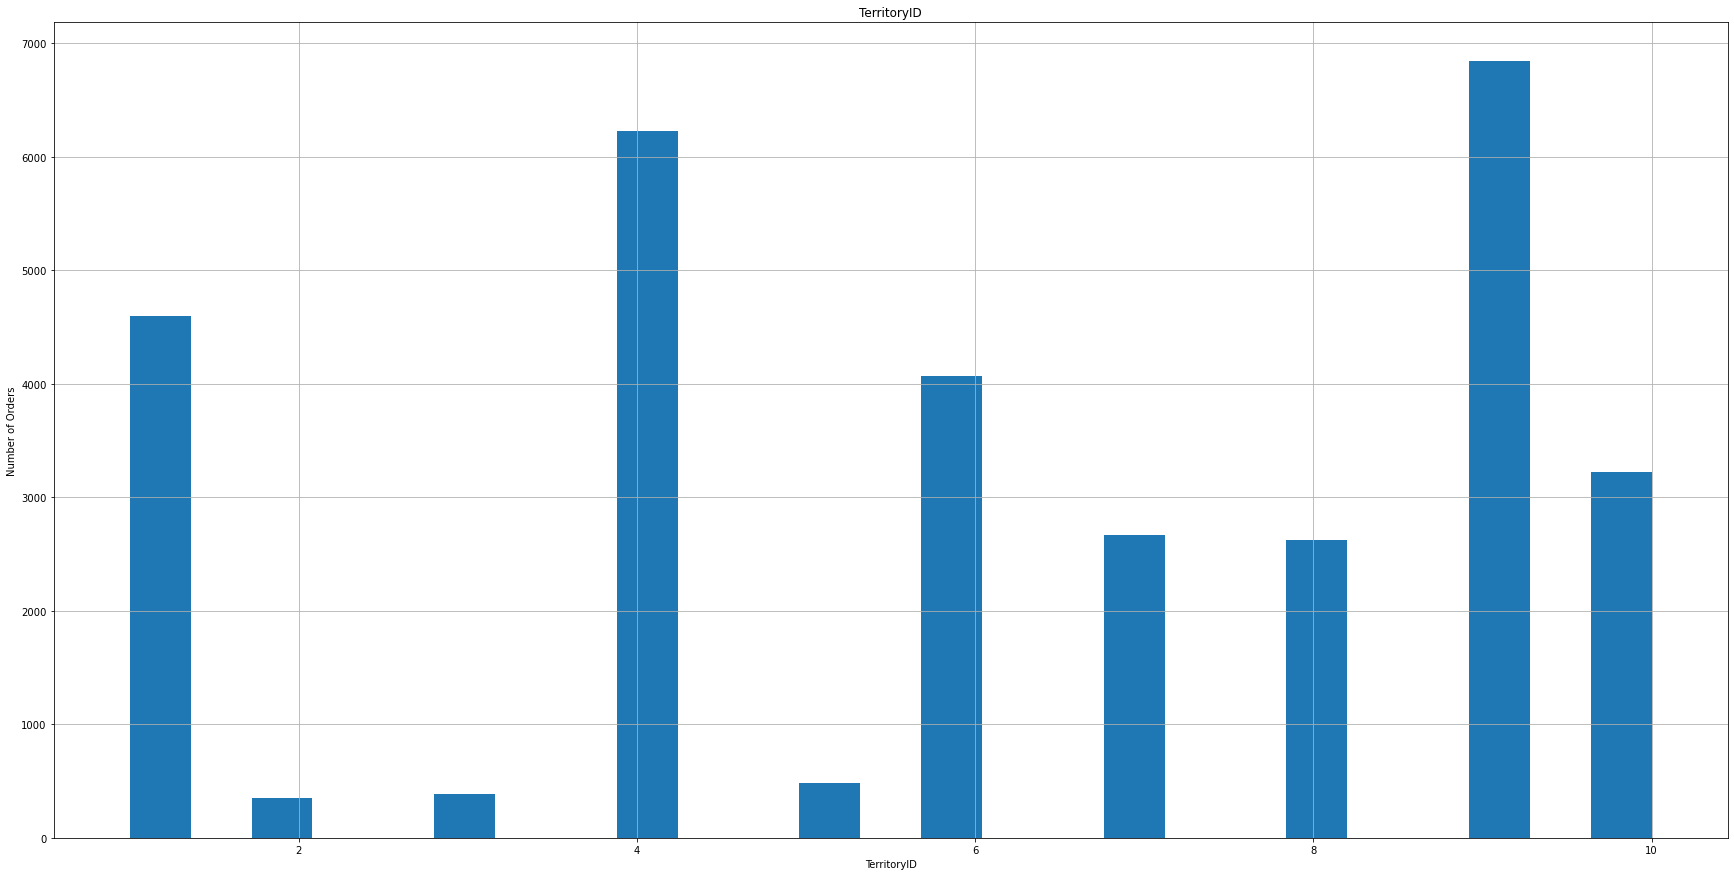

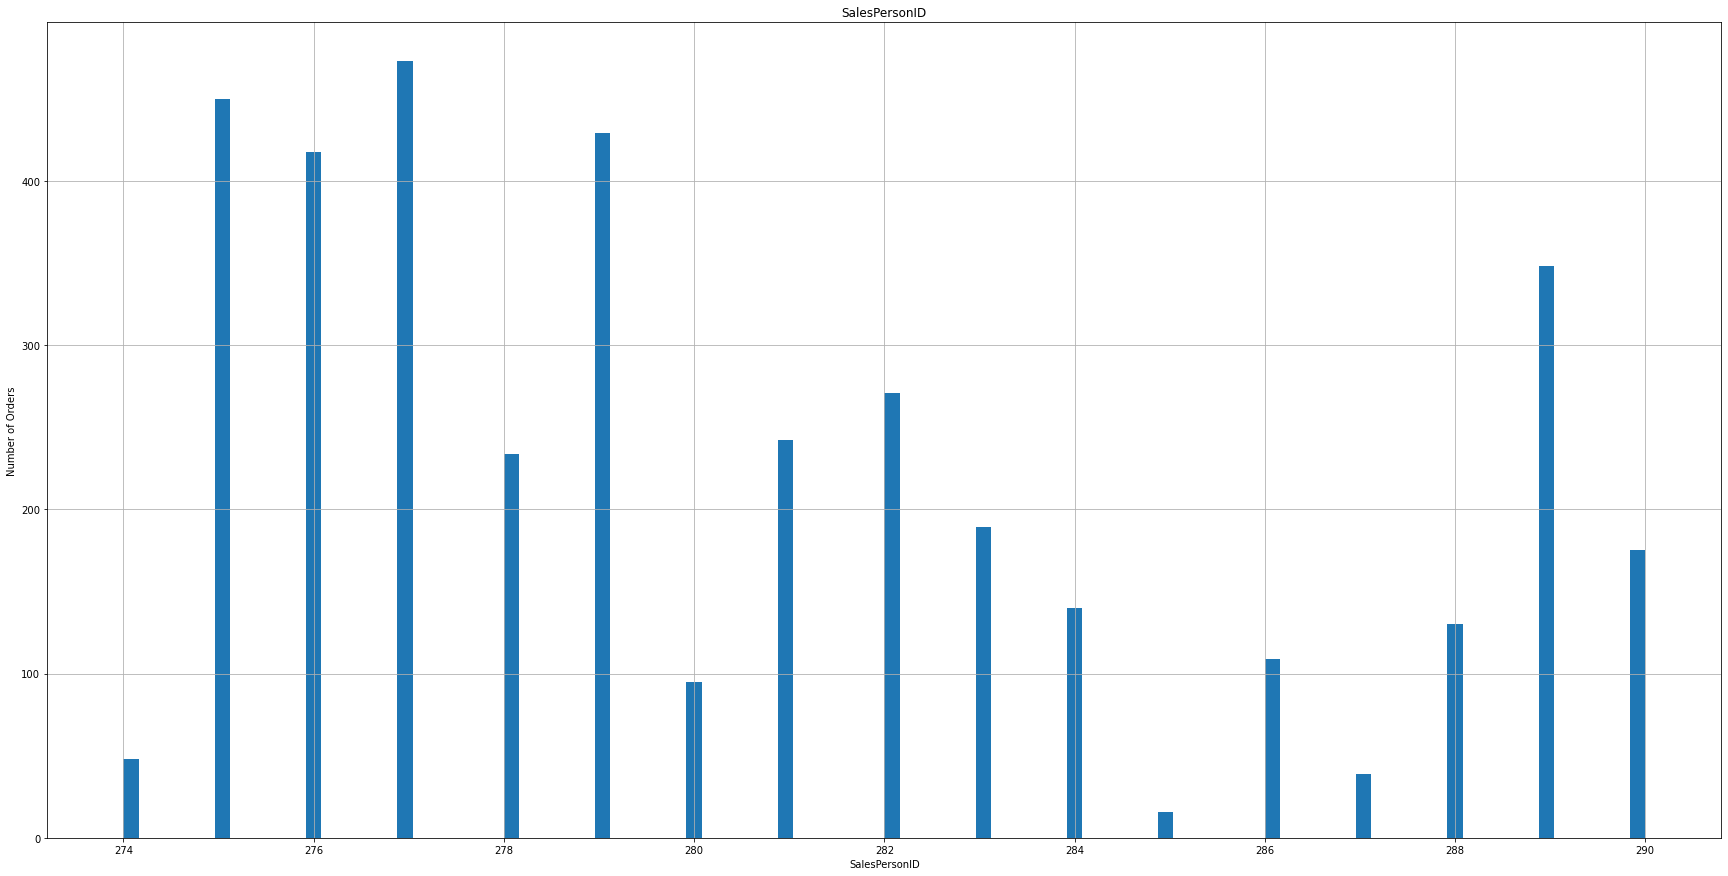

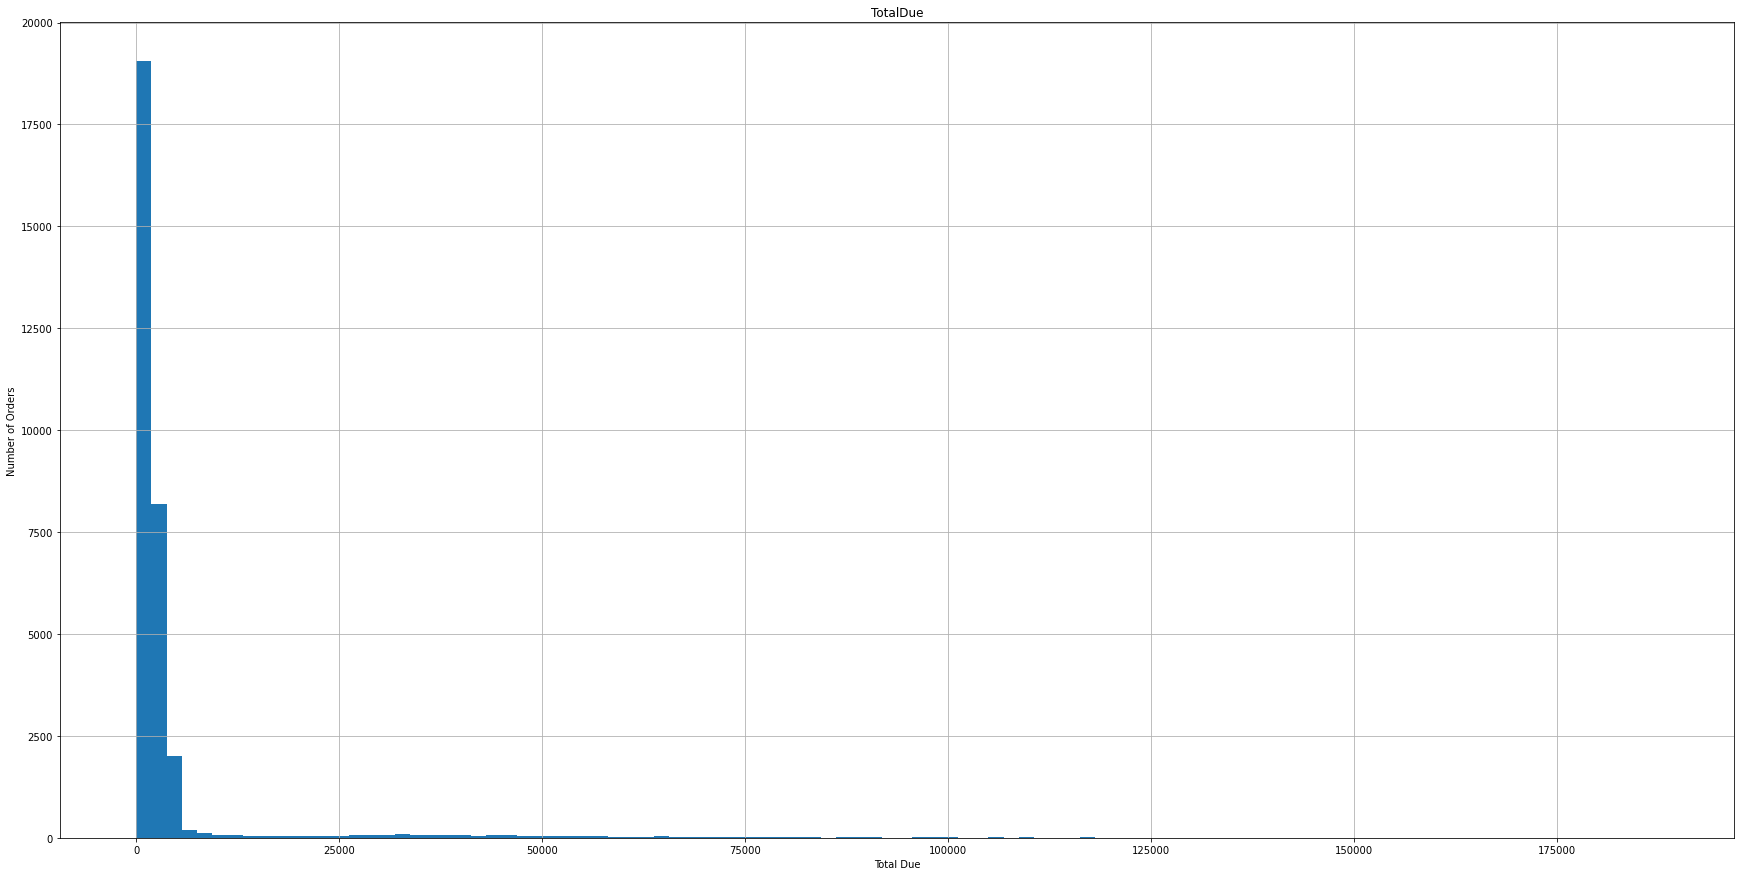

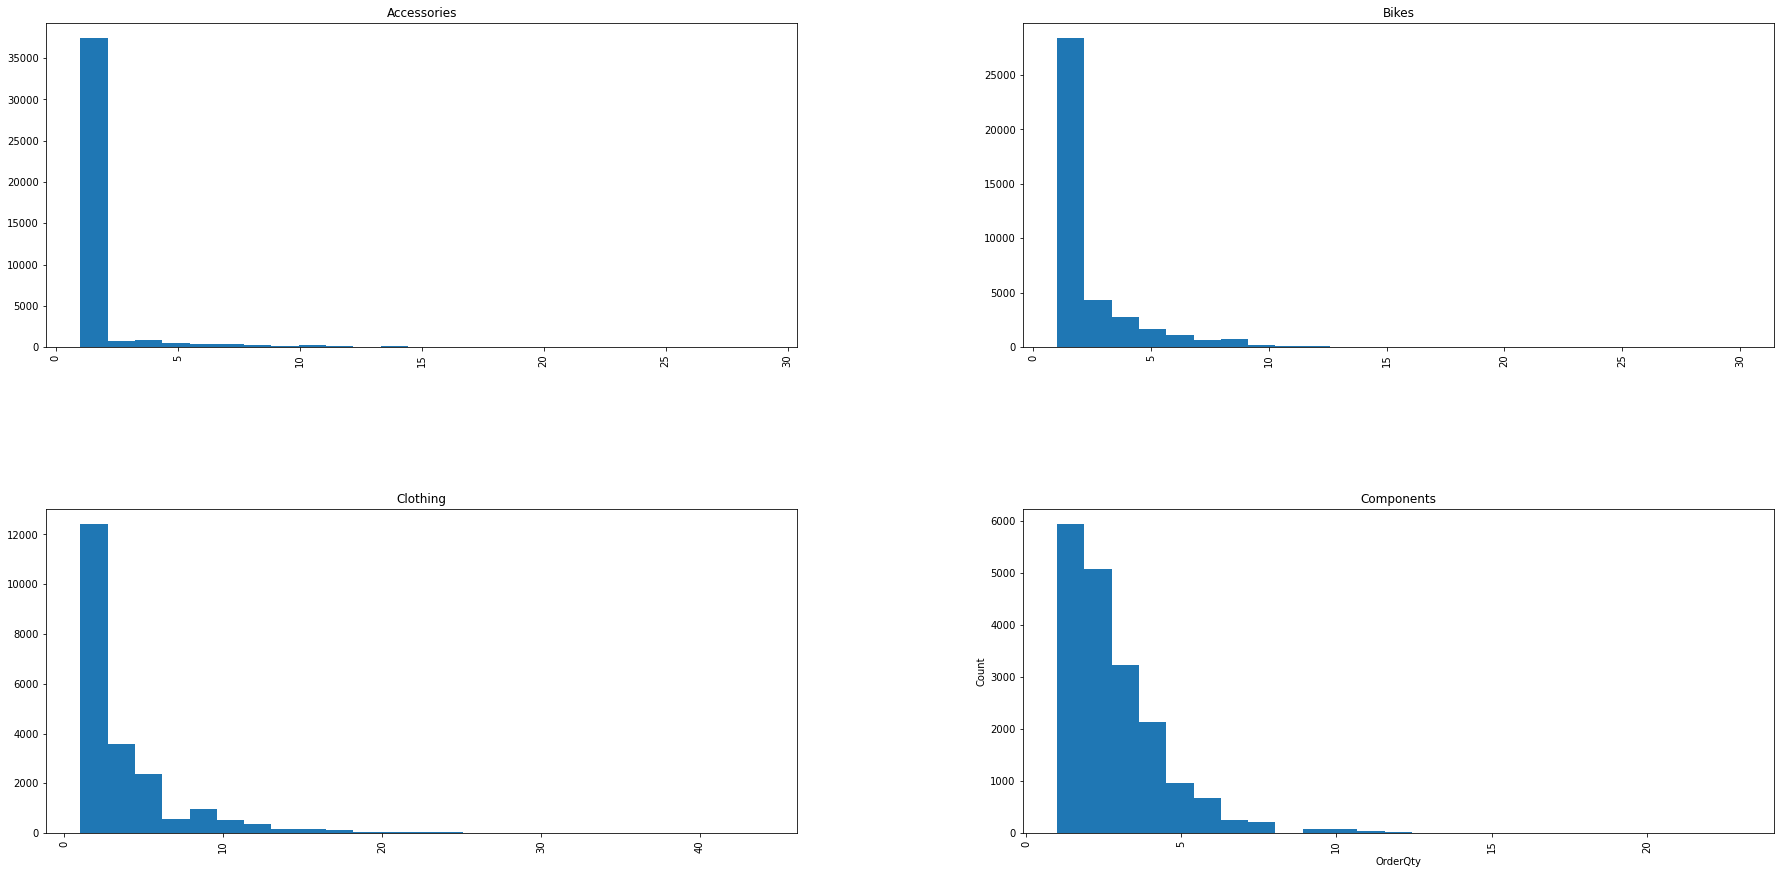

In [340]:
## Histogram of orderqty
final_merged_df.hist(column='OrderQty', bins = 25)
thinkplot.Config(xlabel='OrderQty', ylabel='Count')

## Histogram of unitprice
final_merged_df.hist(column='UnitPrice', bins = 25)
thinkplot.Config(xlabel='UnitPrice', ylabel='Count')

## Histogram of linetotal
final_merged_df.hist(column='LineTotal', bins = 25)
thinkplot.Config(xlabel='LineTotal', ylabel='Count')

## Histogram of orders by territoryID
salesorderheader_df.hist(column='TerritoryID', bins = 25)
thinkplot.Config(xlabel='TerritoryID', ylabel='Number of Orders')

## Histogram of orders by SalesPersonID
salesorderheader_df.hist(column='SalesPersonID', bins =100)
thinkplot.Config(xlabel='SalesPersonID', ylabel='Number of Orders')

## Histogram of TotalDue
salesorderheader_df.hist(column='TotalDue', bins =100)
thinkplot.Config(xlabel='Total Due', ylabel='Number of Orders')

## Histogram of OrderQty by Category
final_merged_df.hist(column='OrderQty', by='Category', bins = 25)
thinkplot.Config(xlabel='OrderQty', ylabel='Count')

In [341]:
## OrderQty summary statistics
print(final_merged_df['OrderQty'].mean())
print(final_merged_df['OrderQty'].median())
print(final_merged_df['OrderQty'].mode())
print(final_merged_df['OrderQty'].describe())
print(final_merged_df['OrderQty'].var())

2.2660797744751355
1.0
0    1
dtype: int64
count    121317.000000
mean          2.266080
std           2.491323
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          44.000000
Name: OrderQty, dtype: float64
6.206691160950733


In [342]:
## Unitprice summary statistics
print(final_merged_df['UnitPrice'].mean())
print(final_merged_df['UnitPrice'].median())
print(final_merged_df['UnitPrice'].mode())
print(final_merged_df['UnitPrice'].describe())
print(final_merged_df['UnitPrice'].var())

465.09349567471924
49.99
0    4.99
dtype: float64
count    121317.000000
mean        465.093496
std         751.885081
min           1.328200
25%          21.490000
50%          49.990000
75%         602.346000
max        3578.270000
Name: UnitPrice, dtype: float64
565331.1746890451


In [343]:
## LineTotal summary statistics
print(final_merged_df['LineTotal'].mean())
print(final_merged_df['LineTotal'].median())
print(final_merged_df['LineTotal'].mode())
print(final_merged_df['LineTotal'].describe())
print(final_merged_df['LineTotal'].var())

905.4492066226923
134.982
0    4.99
dtype: float64
count    121317.000000
mean        905.449207
std        1693.417389
min           1.374000
25%          24.990000
50%         134.982000
75%        1120.490000
max       27893.619000
Name: LineTotal, dtype: float64
2867662.4533027527


In [344]:
## TotalDue summary statistics
print(salesorderheader_df['TotalDue'].mean())
print(salesorderheader_df['TotalDue'].median())
print(salesorderheader_df['TotalDue'].mode())
print(salesorderheader_df['TotalDue'].describe())
print(salesorderheader_df['TotalDue'].var())

3915.9951093564687
865.204
0    3953.9884
dtype: float64
count     31465.000000
mean       3915.995109
std       12515.462713
min           1.518300
25%          62.951900
50%         865.204000
75%        2615.490800
max      187487.825000
Name: TotalDue, dtype: float64
156636806.92822087


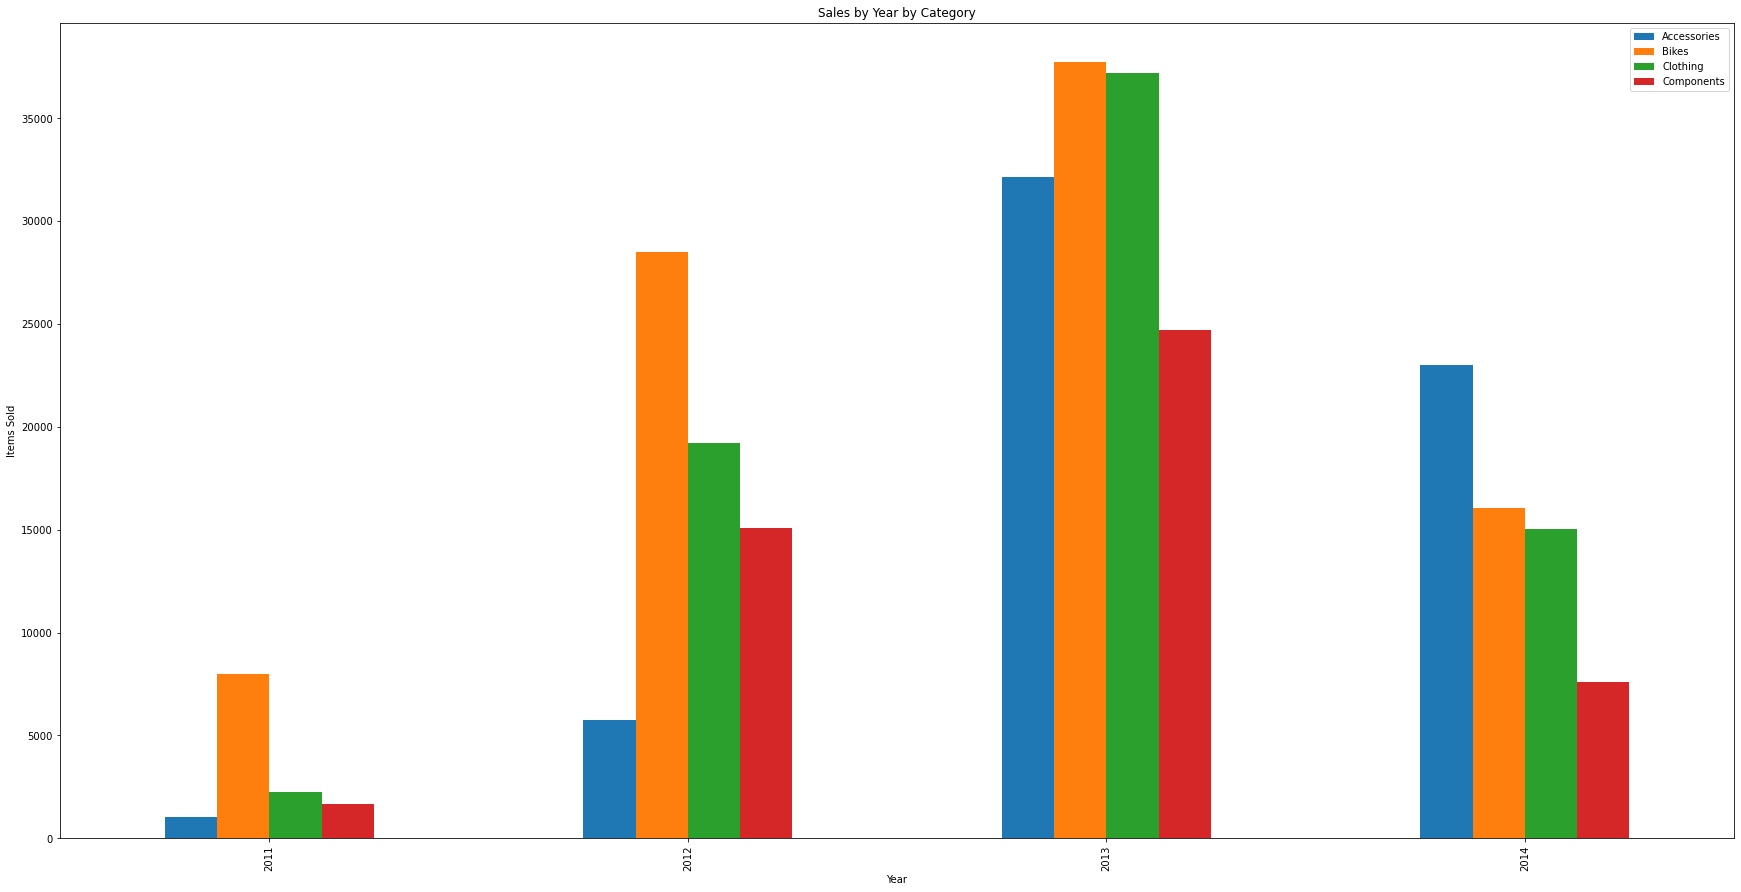

In [345]:
## Number of items sold by category, by year
categories = final_merged_df[['year', 'Category', 'OrderQty']].groupby([pandas.Grouper(key='year'), pandas.Grouper(key='Category')]).sum().unstack().set_axis(['Accessories', 'Bikes', 'Clothing', 'Components'], axis=1, inplace=False)

categories.plot.bar(title='Sales by Year by Category', xlabel='Year', ylabel='Items Sold').legend(bbox_to_anchor=(1,1))

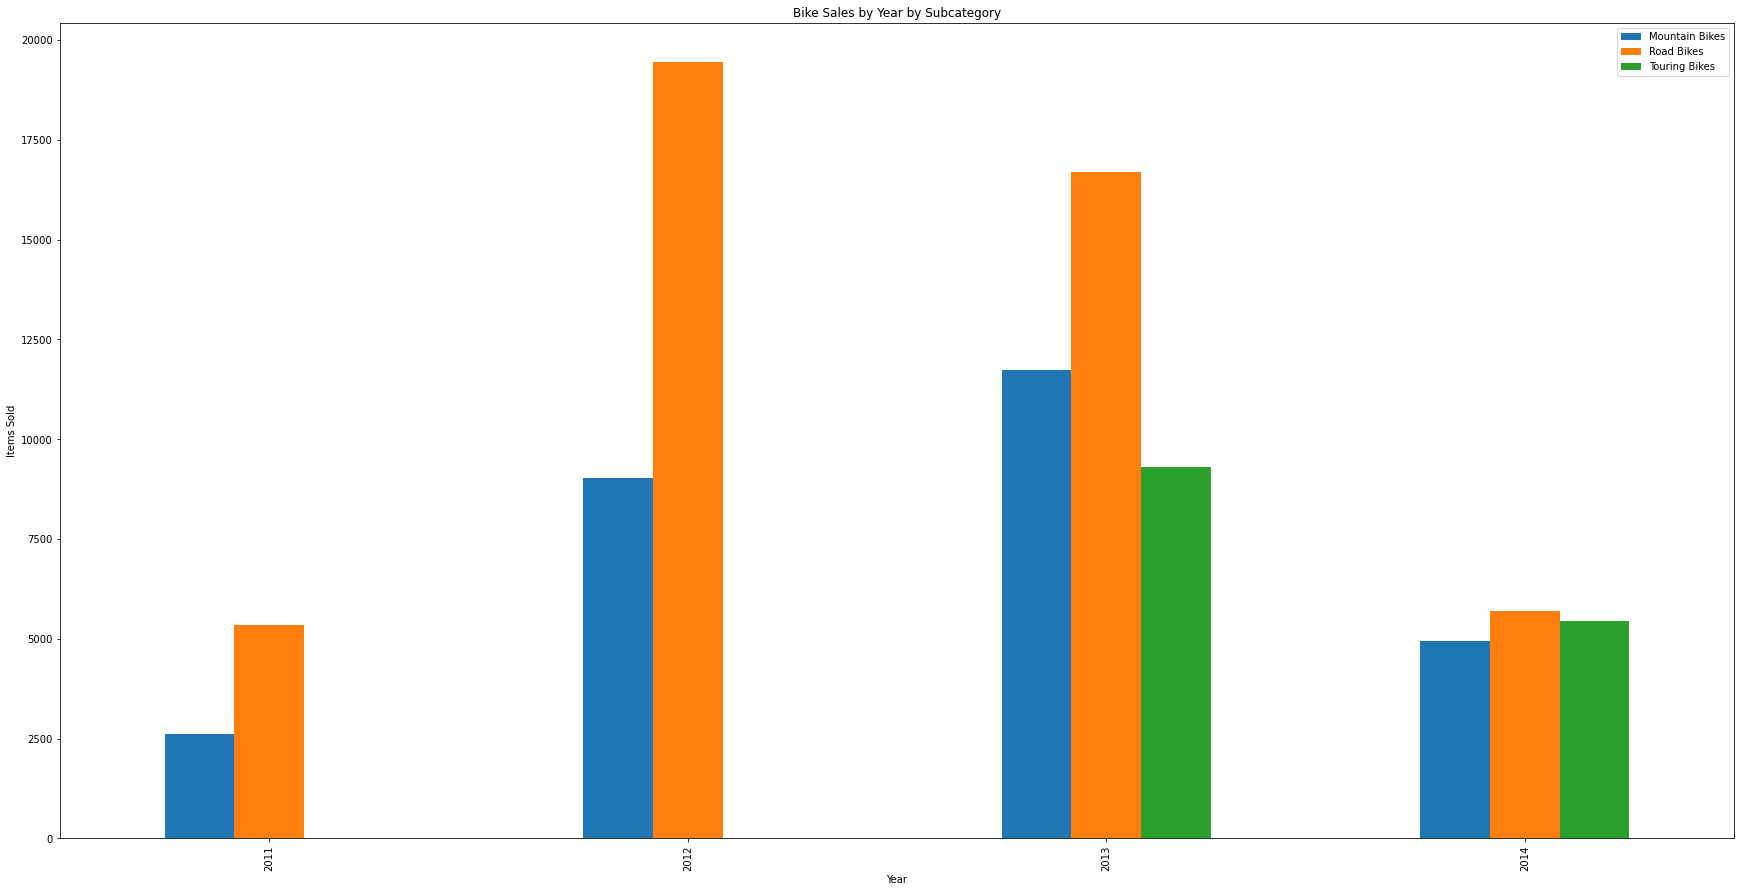

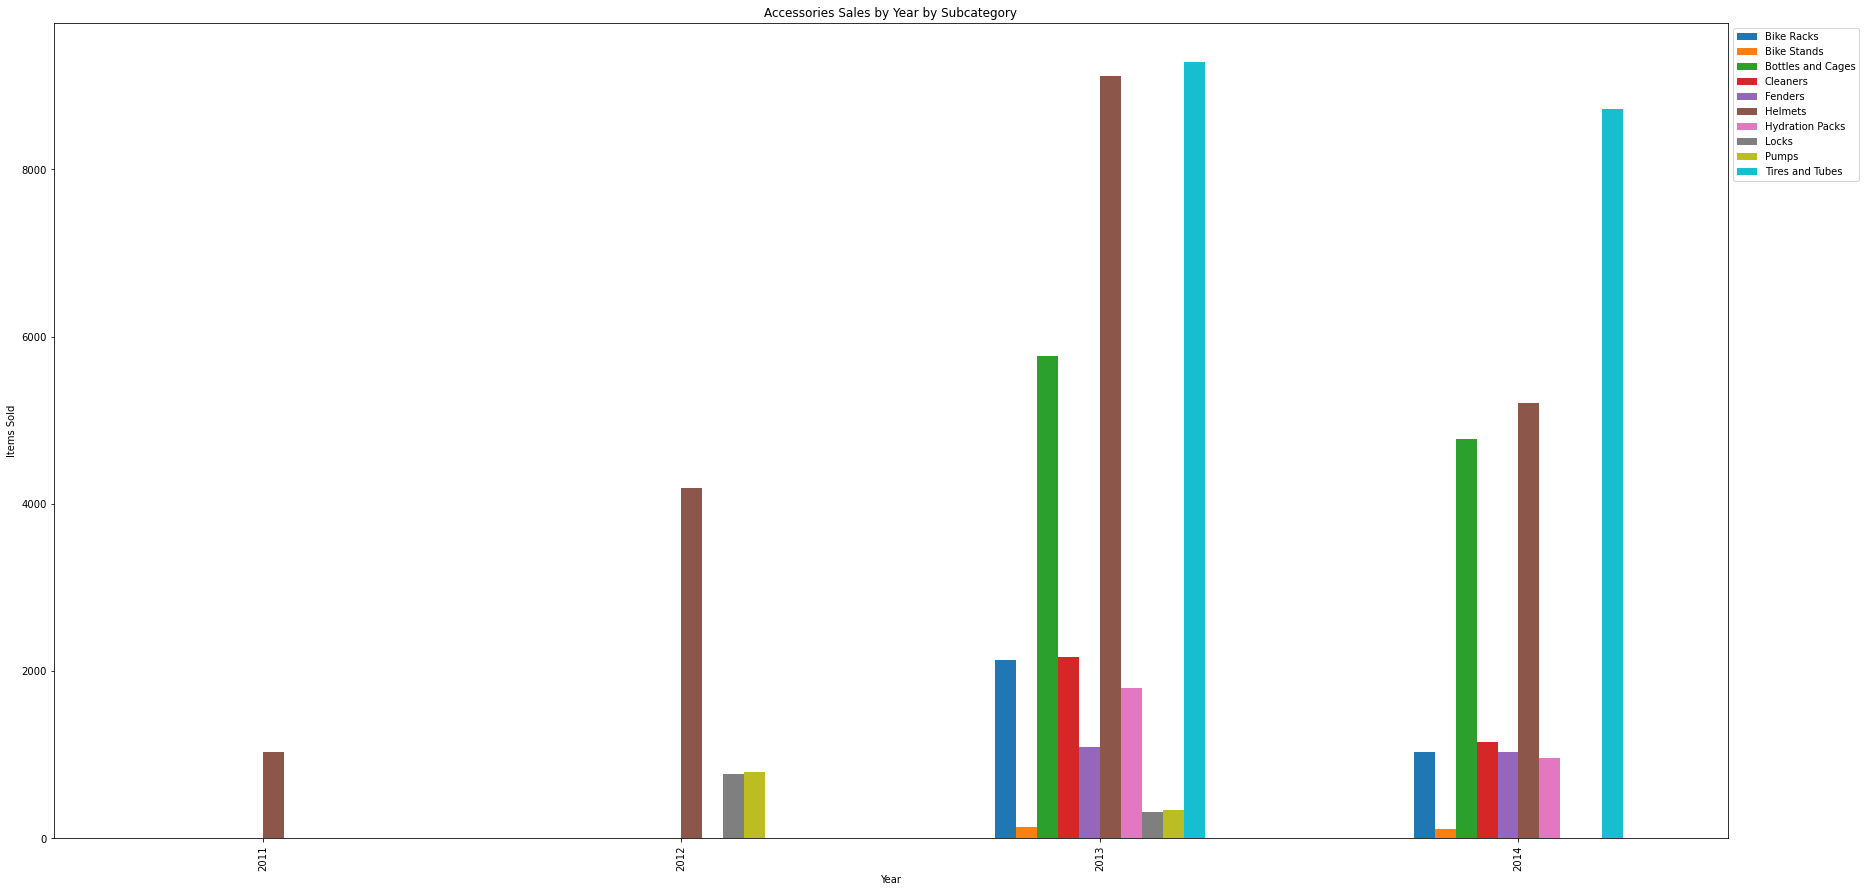

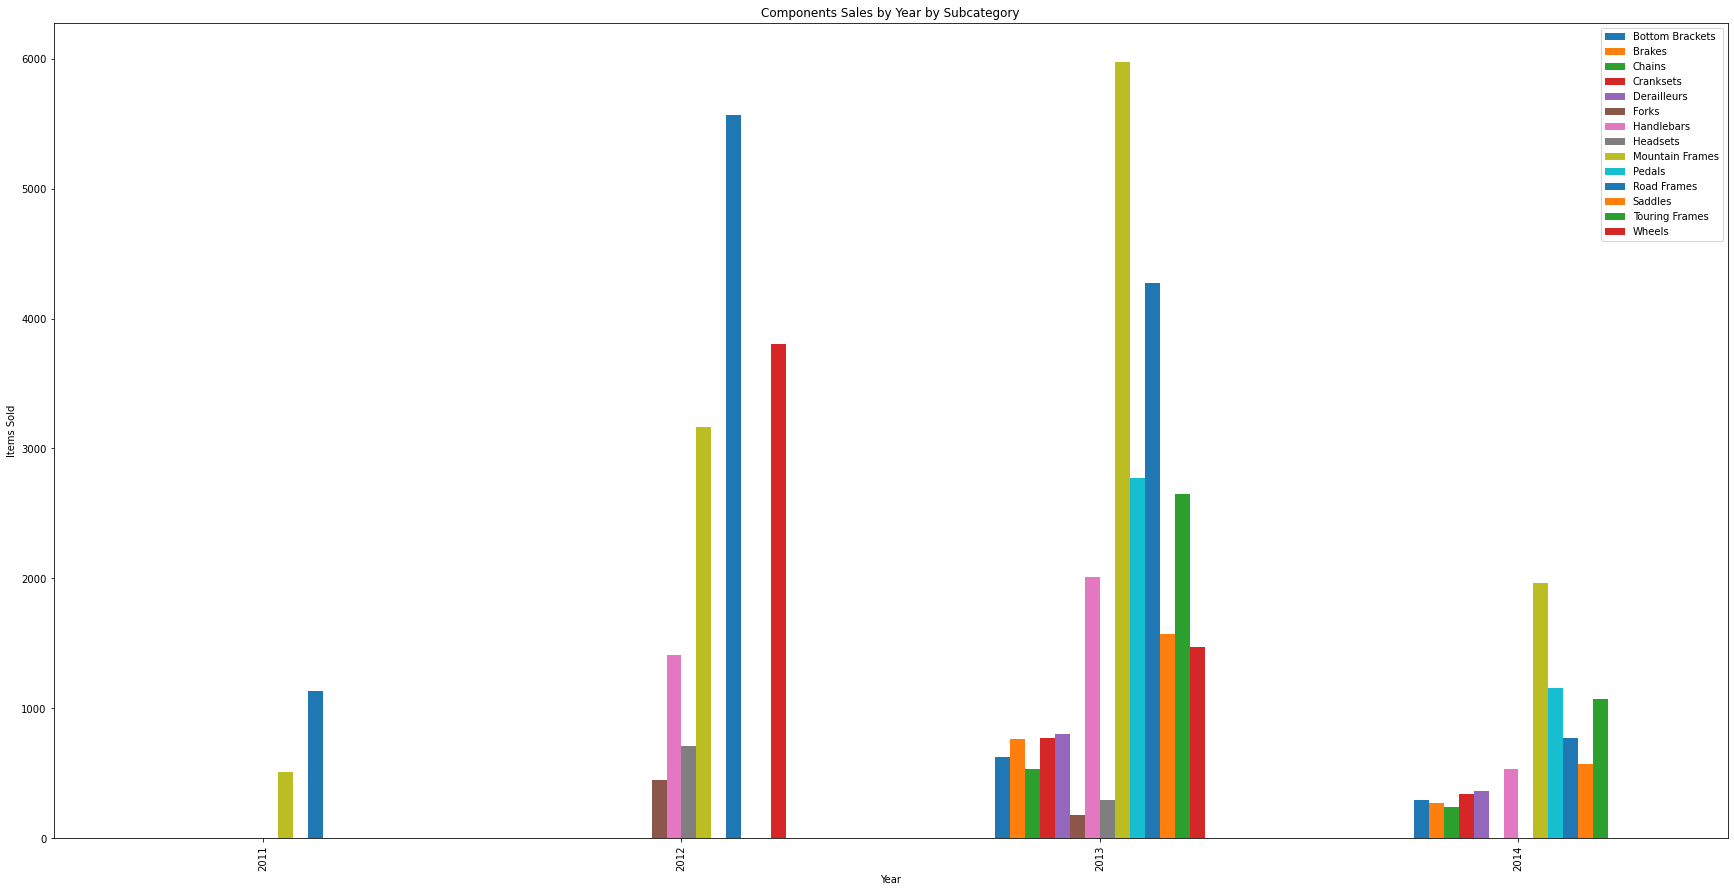

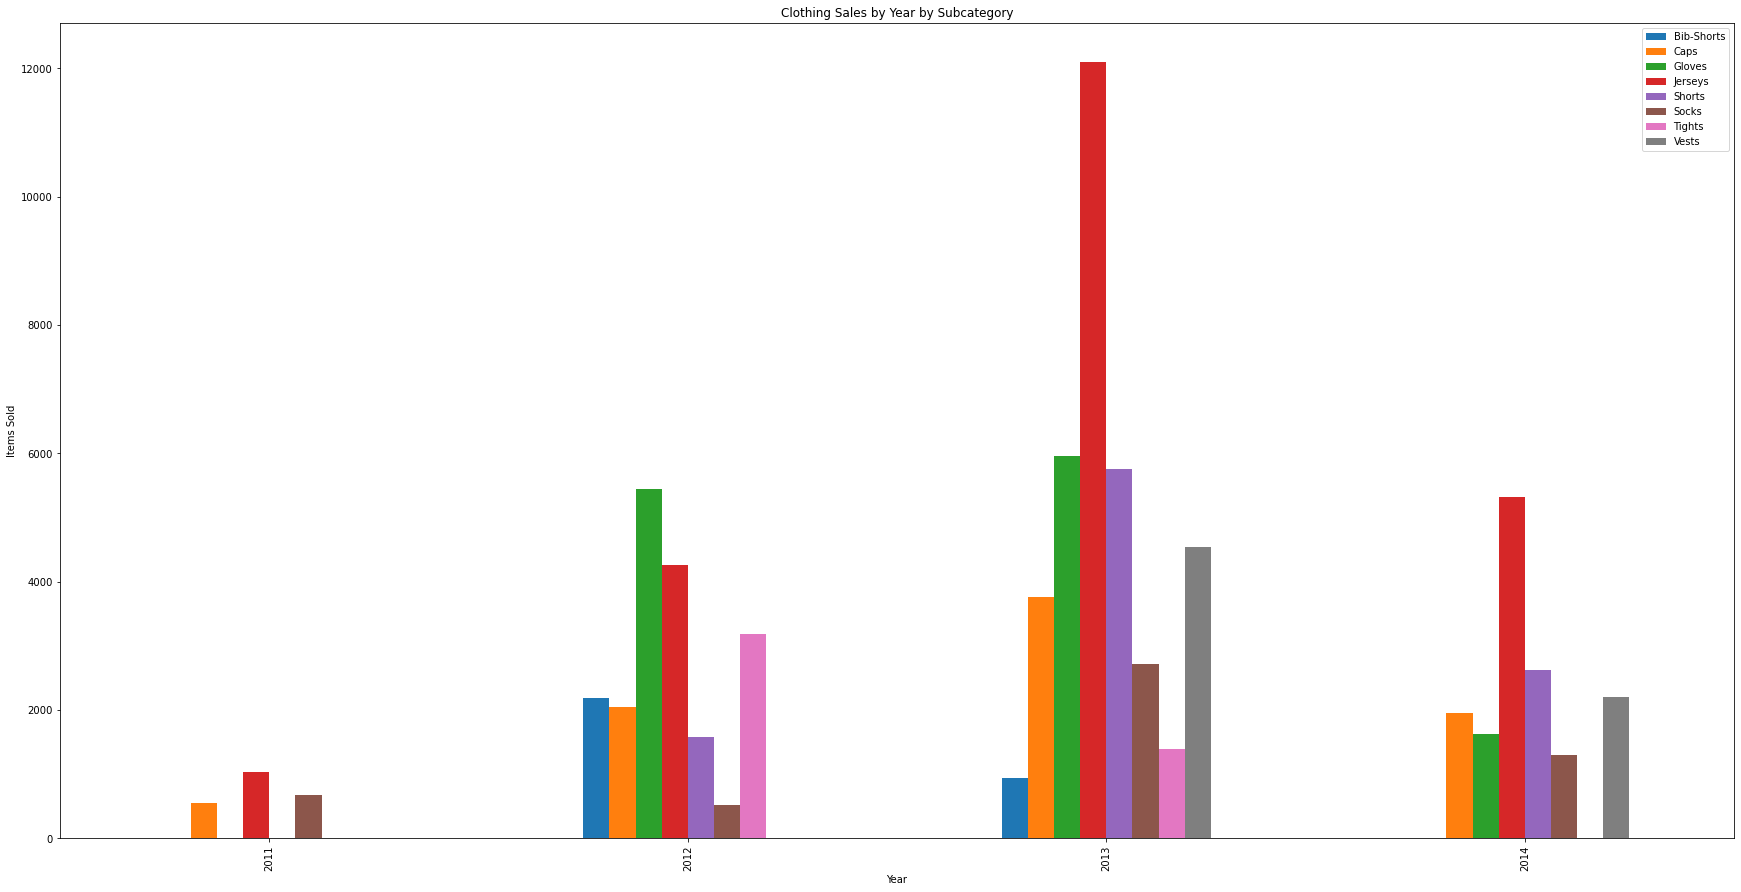

In [346]:
## Number of items sold by subcategory of each category, by year
bikes = final_merged_df.loc[final_merged_df['Category'] == 'Bikes', ['year', 'Subcategory', 'Category', 'OrderQty']].groupby([pandas.Grouper(key='year'), pandas.Grouper(key='Subcategory')]).sum().unstack().set_axis(['Mountain Bikes', 'Road Bikes', 'Touring Bikes'], axis=1, inplace=False)
accessories = final_merged_df.loc[final_merged_df['Category'] == 'Accessories', ['year', 'Subcategory', 'Category', 'OrderQty']].groupby([pandas.Grouper(key='year'), pandas.Grouper(key='Subcategory')]).sum().unstack().set_axis(['Bike Racks', 'Bike Stands', 'Bottles and Cages', 'Cleaners', 'Fenders', 'Helmets', 'Hydration Packs', 'Locks', 'Pumps', 'Tires and Tubes'], axis=1, inplace=False)
components = final_merged_df.loc[final_merged_df['Category'] == 'Components', ['year', 'Subcategory', 'Category', 'OrderQty']].groupby([pandas.Grouper(key='year'), pandas.Grouper(key='Subcategory')]).sum().unstack().set_axis(['Bottom Brackets','Brakes','Chains','Cranksets','Derailleurs','Forks','Handlebars','Headsets','Mountain Frames','Pedals','Road Frames','Saddles', 'Touring Frames', 'Wheels'], axis=1, inplace=False)
clothing = final_merged_df.loc[final_merged_df['Category'] == 'Clothing', ['year', 'Subcategory', 'Category', 'OrderQty']].groupby([pandas.Grouper(key='year'), pandas.Grouper(key='Subcategory')]).sum().unstack().set_axis(['Bib-Shorts', 'Caps', 'Gloves', 'Jerseys', 'Shorts', 'Socks', 'Tights', 'Vests'], axis=1, inplace=False)

bikes.plot.bar(title='Bike Sales by Year by Subcategory', xlabel='Year', ylabel='Items Sold').legend(bbox_to_anchor=(1,1))
accessories.plot.bar(title='Accessories Sales by Year by Subcategory', xlabel='Year', ylabel='Items Sold').legend(bbox_to_anchor=(1,1))
components.plot.bar(title='Components Sales by Year by Subcategory', xlabel='Year', ylabel='Items Sold').legend(bbox_to_anchor=(1,1))
clothing.plot.bar(title='Clothing Sales by Year by Subcategory', xlabel='Year', ylabel='Items Sold').legend(bbox_to_anchor=(1,1))

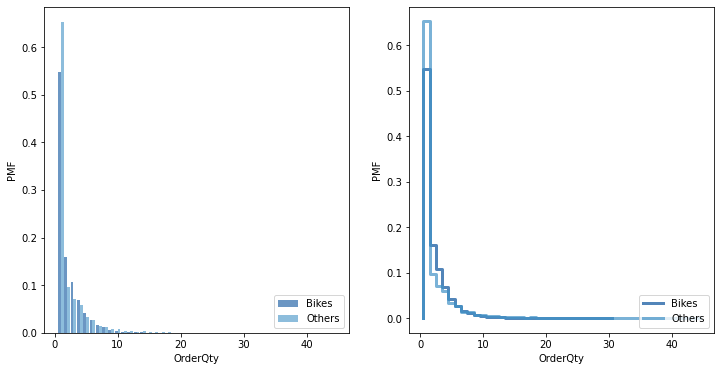

In [347]:
## PMF comparison of orderqty from Bikes vs all others
bikes_pmf = final_merged_df.loc[final_merged_df['Category'] == 'Bikes', ['OrderQty']]
bikes_pmf = thinkstats2.Pmf(bikes_pmf['OrderQty'], label='Bikes')
others_pmf = final_merged_df.loc[final_merged_df['Category'] != 'Bikes', ['OrderQty']]
others_pmf = thinkstats2.Pmf(others_pmf['OrderQty'], label='Others')

thinkplot.PrePlot(2, cols=2)
thinkplot.Hist(bikes_pmf, align='right', width=0.45)
thinkplot.Hist(others_pmf, align='left', width=0.45)
thinkplot.Config(xlabel='OrderQty', ylabel='PMF')

thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Pmfs([bikes_pmf, others_pmf])
thinkplot.Config(xlabel='OrderQty', ylabel='PMF')

/Users/Shared/OneDrive - Bellevue University/DSC 530 - Data Exploration and Analysis/mkzoucha_dsc530/ZouchaM_Completed_Assignments/Final Project Data/thinkstats2.py:1038: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.ps = np.cumsum(freqs, dtype=np.float)


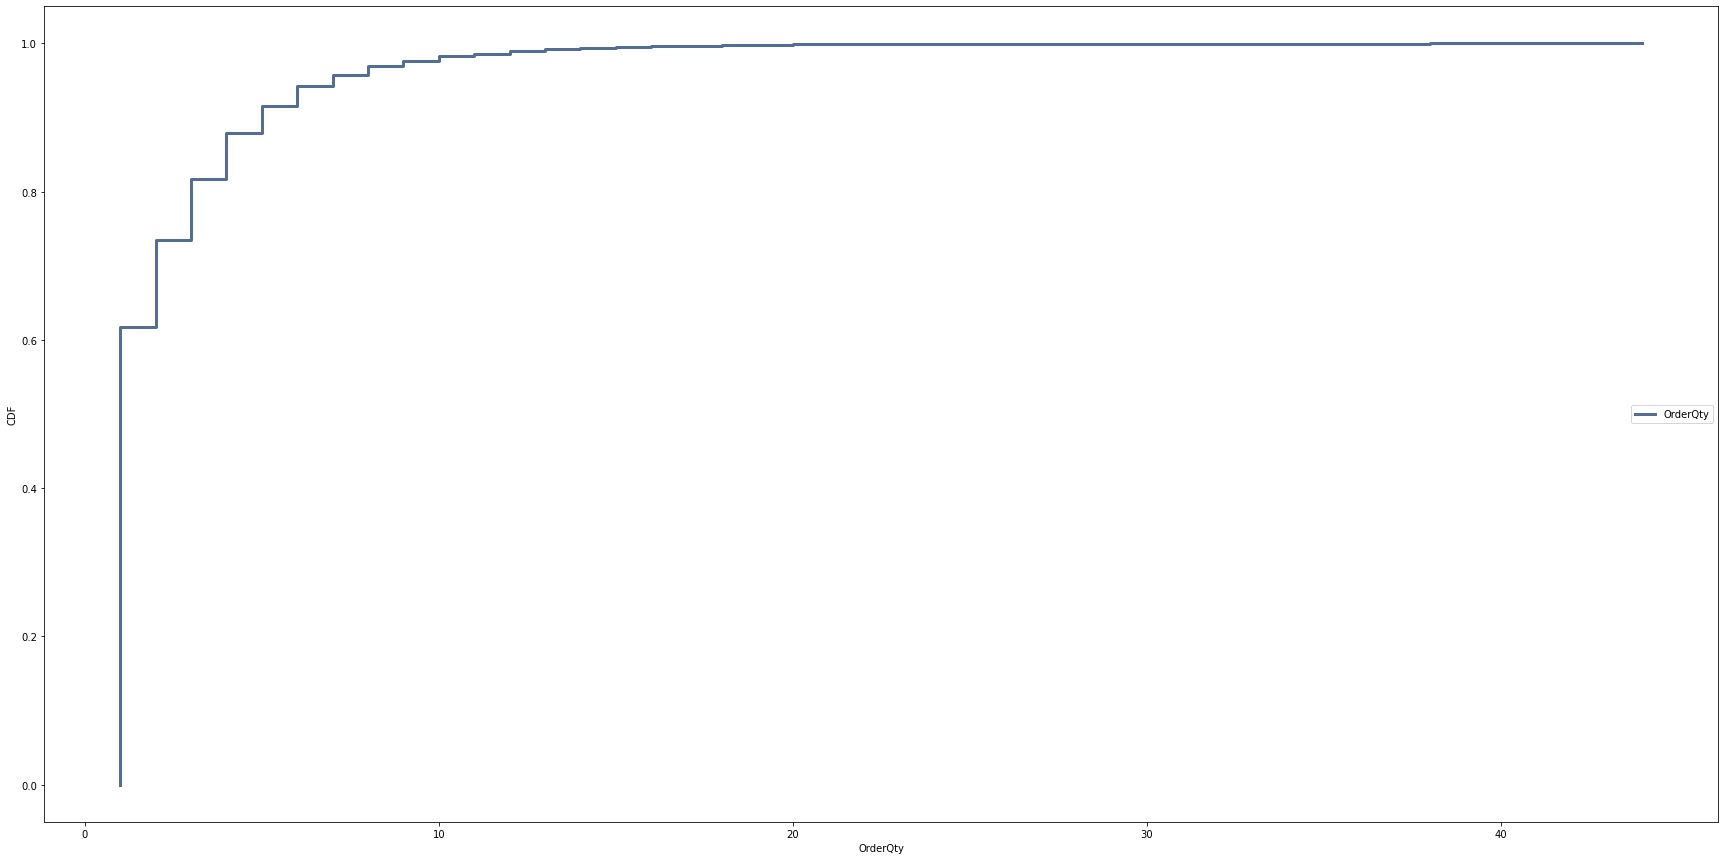

In [348]:
##CDF of orderqty
cdf = thinkstats2.Cdf(final_merged_df['OrderQty'], label='OrderQty')
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='OrderQty', ylabel='CDF', loc='right')

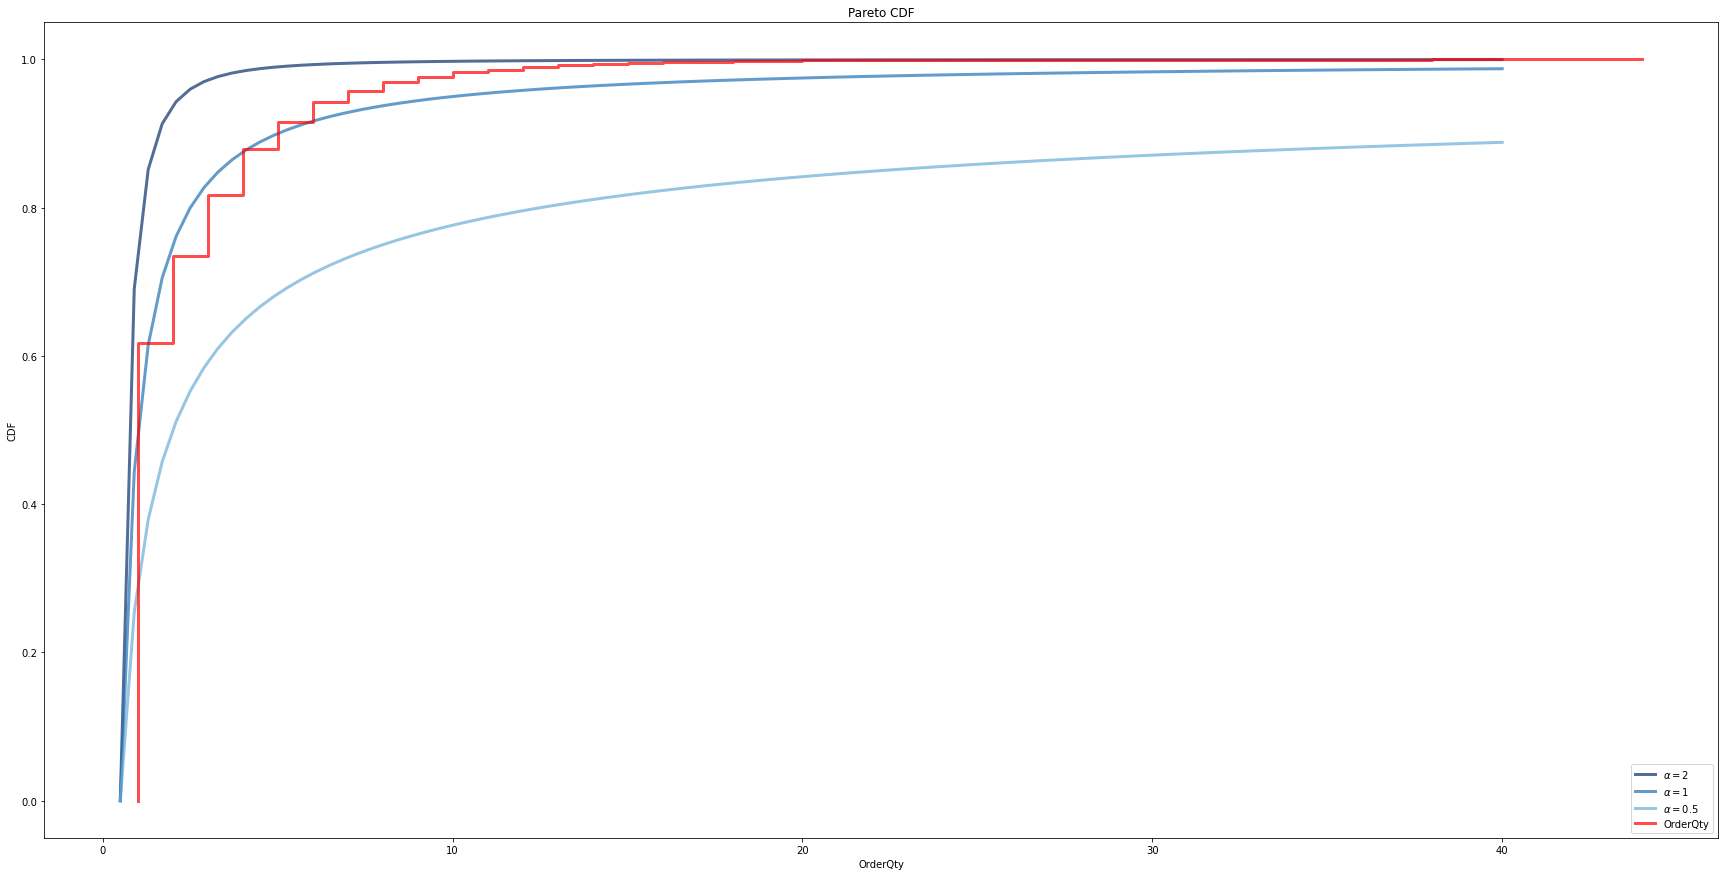

In [349]:
## Pareto Distribution

xmin = 0.5

thinkplot.PrePlot(4)
for alpha in [2.0, 1.0, 0.5]:
    xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 40, n=100)
    thinkplot.Plot(xs, ps, label=r'$\alpha=%g$' % alpha)

thinkplot.Cdf(cdf, color='red')
thinkplot.Config(title='Pareto CDF', xlabel='OrderQty',
                 ylabel='CDF', loc='lower right')

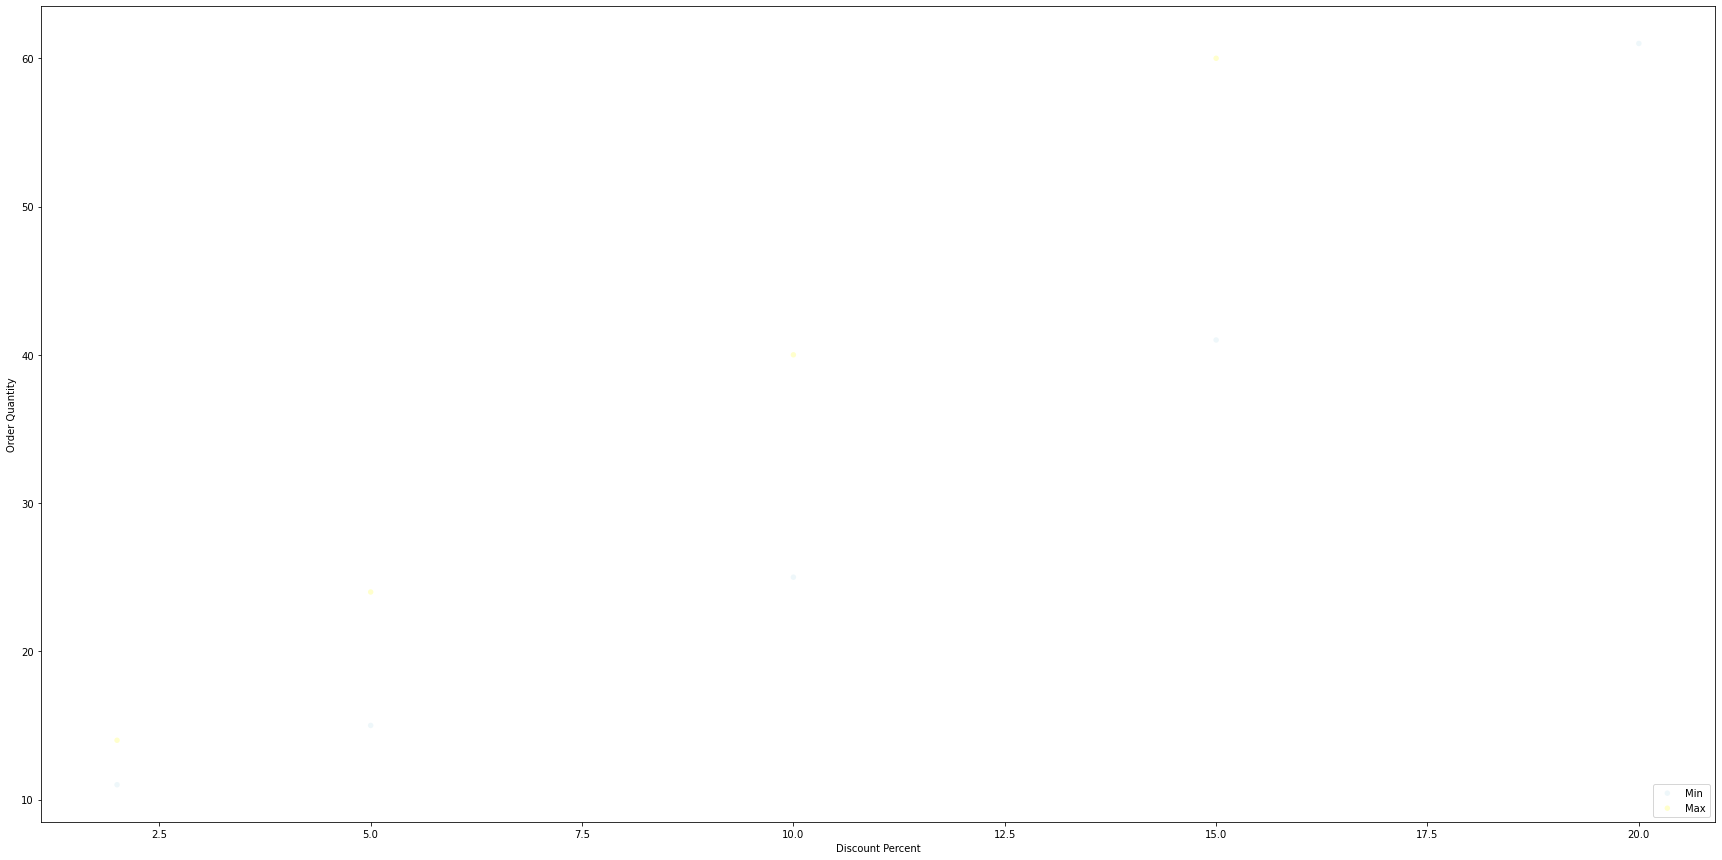

In [350]:
## Scatterplot orderqty vs discountpct
thinkplot.Scatter(specialoffer_df.loc[(specialoffer_df['SpecialOfferID'] >= 2) & (specialoffer_df['SpecialOfferID'] <= 6), ['DiscountPct']], specialoffer_df.loc[(specialoffer_df['SpecialOfferID'] >= 2) & (specialoffer_df['SpecialOfferID'] <= 6), ['MinQty']], color='lightblue', label='Min')
thinkplot.Scatter(specialoffer_df.loc[(specialoffer_df['SpecialOfferID'] >= 2) & (specialoffer_df['SpecialOfferID'] <= 6), ['DiscountPct']], specialoffer_df.loc[(specialoffer_df['SpecialOfferID'] >= 2) & (specialoffer_df['SpecialOfferID'] <= 6), ['MaxQty']], color='yellow', label='Max')
thinkplot.Config(xlabel='Discount Percent',
                 ylabel='Order Quantity')

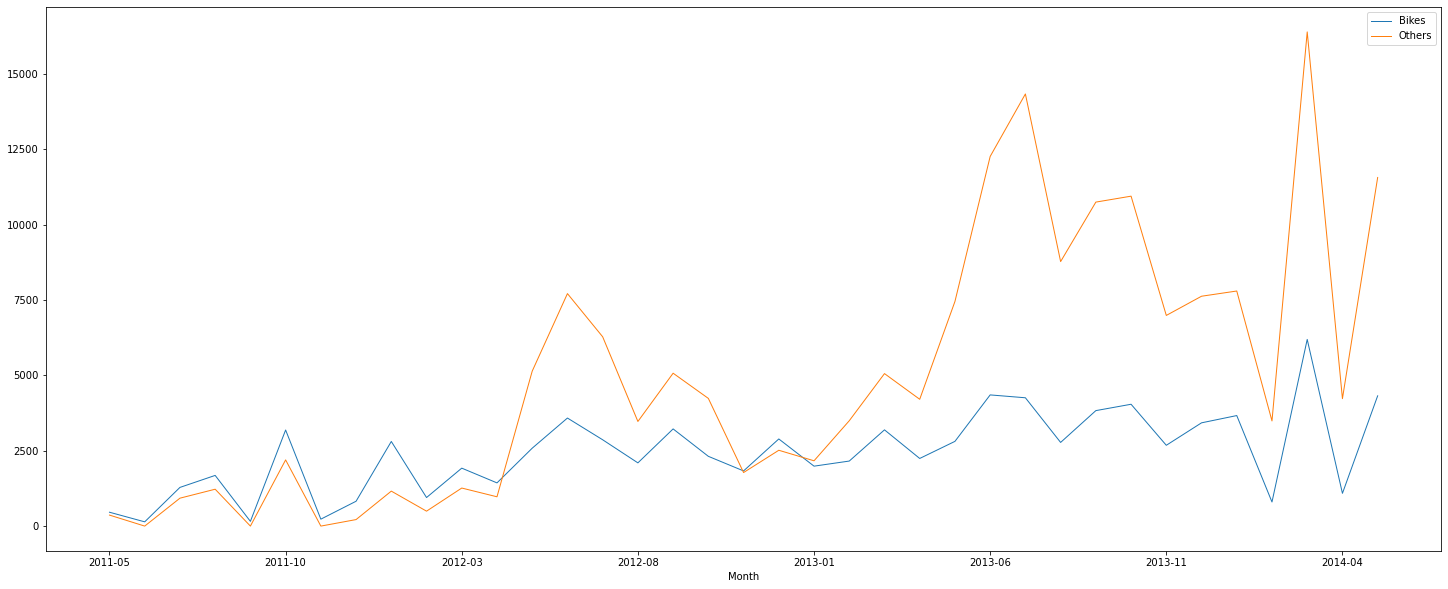

In [396]:
## Sum / unpivot order totals per category per month, combine into one data frame for regression
bikes_lm_df = final_merged_df.loc[final_merged_df['Category'] == 'Bikes', ['month_date', 'Category', 'OrderQty']].groupby([pandas.Grouper(key='month_date'), pandas.Grouper(key='Category')]).sum().unstack().reset_index().set_axis(['Month','Bikes'], axis=1, inplace=False).fillna(0)
accessories_lm_df = final_merged_df.loc[final_merged_df['Category'] == 'Accessories', ['month_date', 'Category', 'OrderQty']].groupby([pandas.Grouper(key='month_date'), pandas.Grouper(key='Category')]).sum().unstack().reset_index().set_axis(['Month','Accessories'], axis=1, inplace=False).fillna(0)
components_lm_df = final_merged_df.loc[final_merged_df['Category'] == 'Components', ['month_date', 'Category', 'OrderQty']].groupby([pandas.Grouper(key='month_date'), pandas.Grouper(key='Category')]).sum().unstack().reset_index().set_axis(['Month','Components'], axis=1, inplace=False).fillna(0)
clothing_lm_df = final_merged_df.loc[final_merged_df['Category'] == 'Clothing', ['month_date', 'Category', 'OrderQty']].groupby([pandas.Grouper(key='month_date'), pandas.Grouper(key='Category')]).sum().unstack().reset_index().set_axis(['Month','Clothing'], axis=1, inplace=False).fillna(0)
others_lm_df = final_merged_df.loc[final_merged_df['Category'] != 'Bikes', ['month_date', 'Category', 'OrderQty']].groupby(pandas.Grouper(key='month_date')).sum().unstack().reset_index().fillna(0).set_axis(['Drop', 'Month','Others'], axis=1, inplace=False).fillna(0)[['Month', 'Others']]

lm_merged_df = bikes_lm_df.merge(others_lm_df, how = "left", left_on = "Month", right_on = "Month").merge(accessories_lm_df, how = "left", left_on = "Month", right_on = "Month").merge(components_lm_df, how = "left", left_on = "Month", right_on = "Month").merge(clothing_lm_df, how = "left", left_on = "Month", right_on = "Month").fillna(0).reset_index()

lm_merged_df[['Month', 'Bikes', 'Others']].plot(x='Month', linewidth=1, figsize=(25,10))

lm_merged_df['months_from_start'] = (lm_merged_df.index - lm_merged_df.index[0])


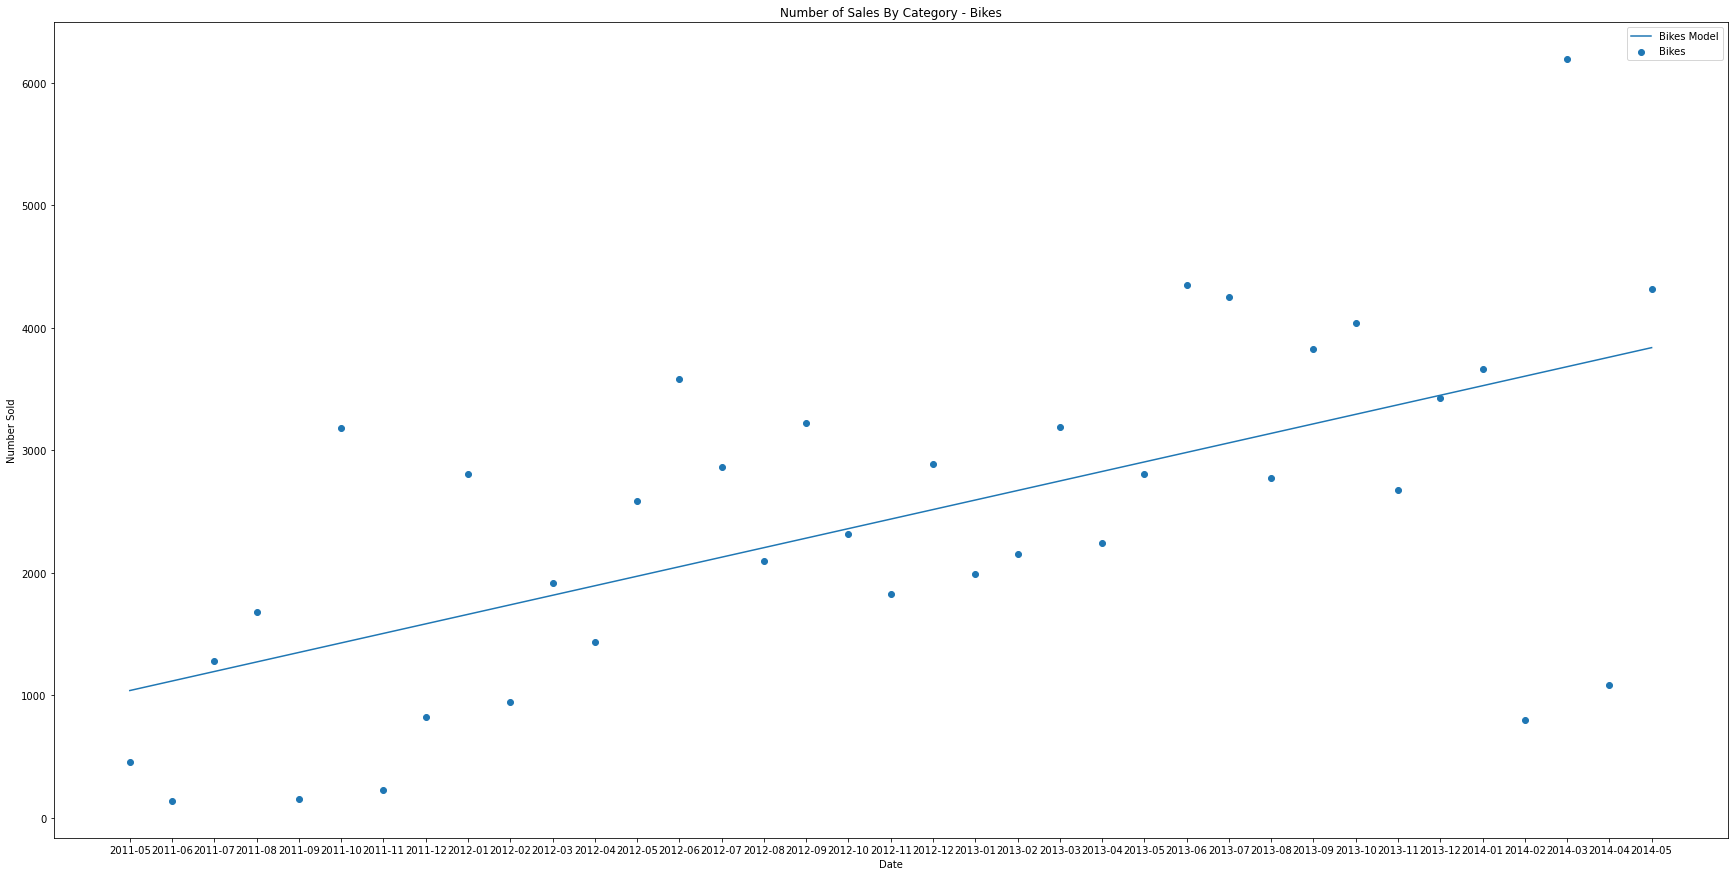

In [368]:
## Linear regression using numpy for bikes

lm = np.arange(lm_merged_df['Month'].size)

lm_fit = np.polyfit(lm, lm_merged_df['Bikes'], deg=1)
lm_fit_function = np.poly1d(lm_fit)
plt.plot(lm_merged_df['Month'], lm_fit_function(lm), label='Bikes Model')
plt.scatter(lm_merged_df['Month'], lm_merged_df['Bikes'], label='Bikes')

plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Number of Sales By Category - Bikes')
plt.legend(loc='best')
plt.show()

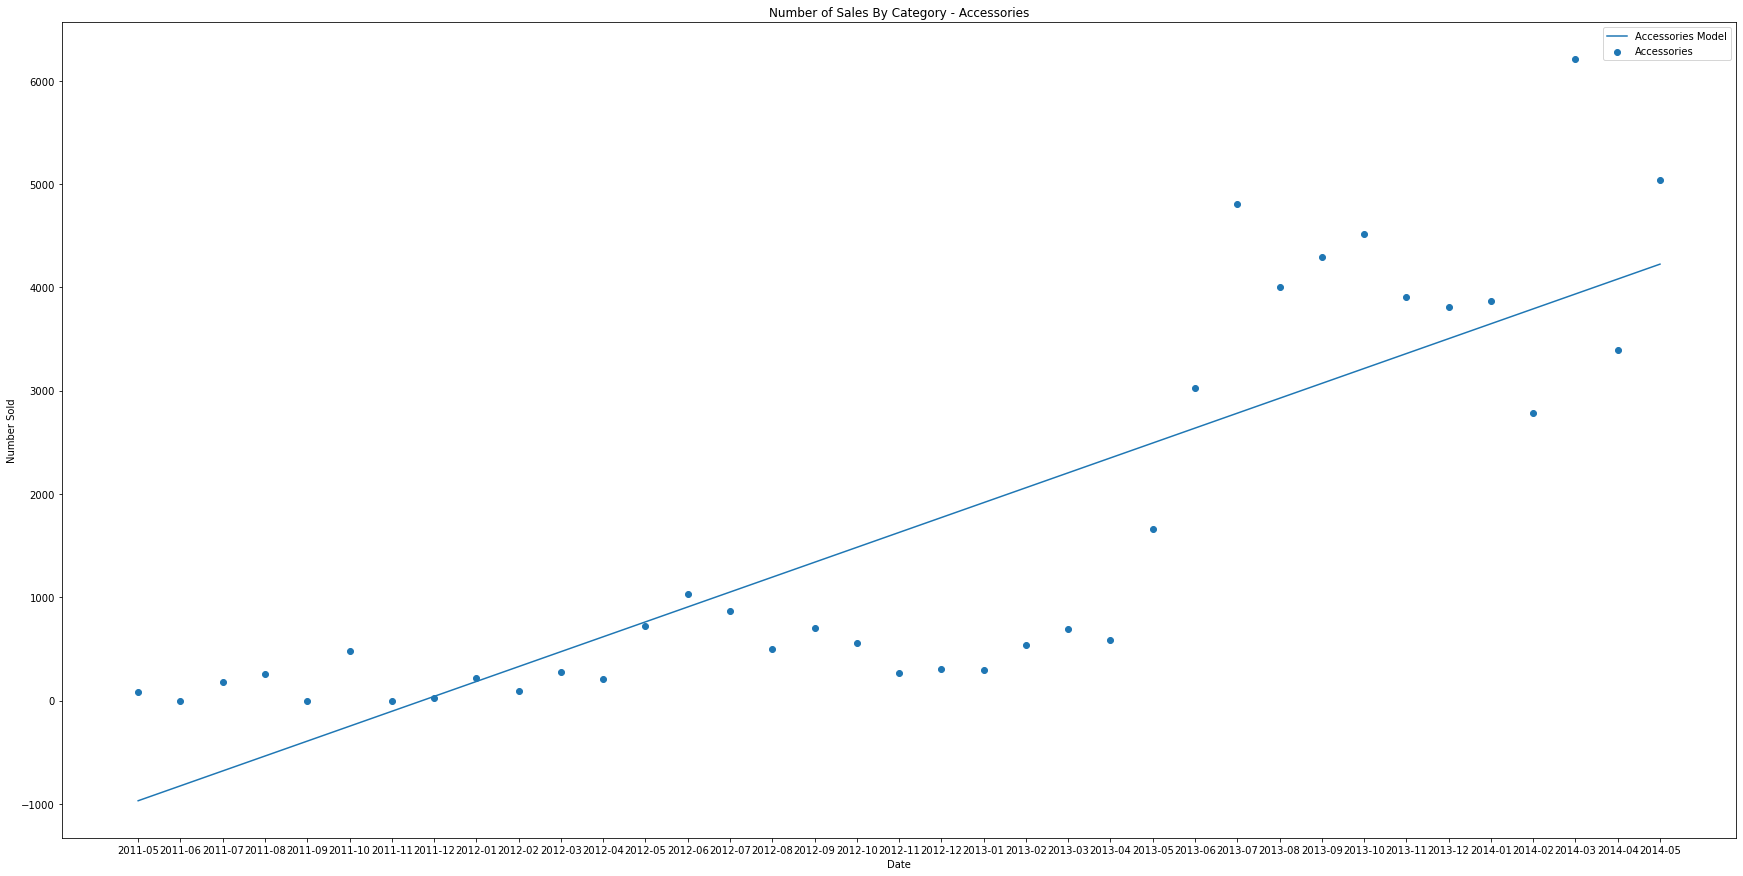

In [369]:
## Linear regression using numpy for accesories

lm = np.arange(lm_merged_df['Month'].size)

lm_fit = np.polyfit(lm, lm_merged_df['Accessories'], deg=1)
lm_fit_function = np.poly1d(lm_fit)
plt.plot(lm_merged_df['Month'], lm_fit_function(lm), label='Accessories Model')
plt.scatter(lm_merged_df['Month'], lm_merged_df['Accessories'], label='Accessories')

plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Number of Sales By Category - Accessories')
plt.legend(loc='best')
plt.show()

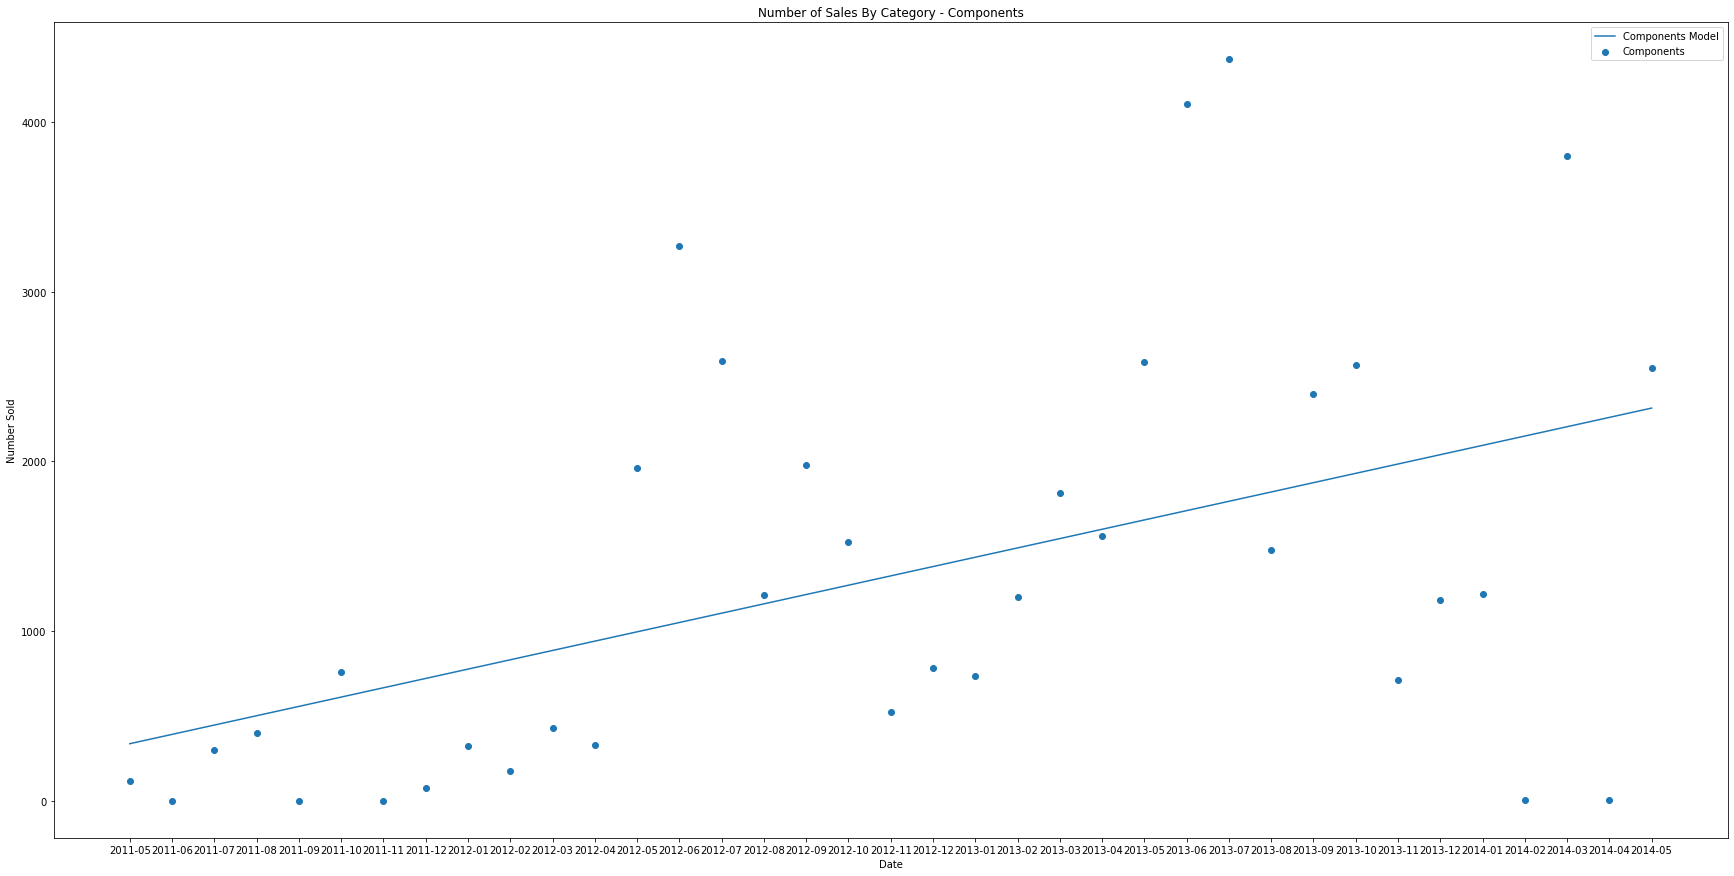

In [375]:
## Linear regression using numpy for components

lm_fit = np.polyfit(lm, lm_merged_df['Components'], deg=1)
lm_fit_function = np.poly1d(lm_fit)
plt.plot(lm_merged_df['Month'], lm_fit_function(lm), label='Components Model')
plt.scatter(lm_merged_df['Month'], lm_merged_df['Components'], label='Components')

plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Number of Sales By Category - Components')
plt.legend(loc='best')
plt.show()

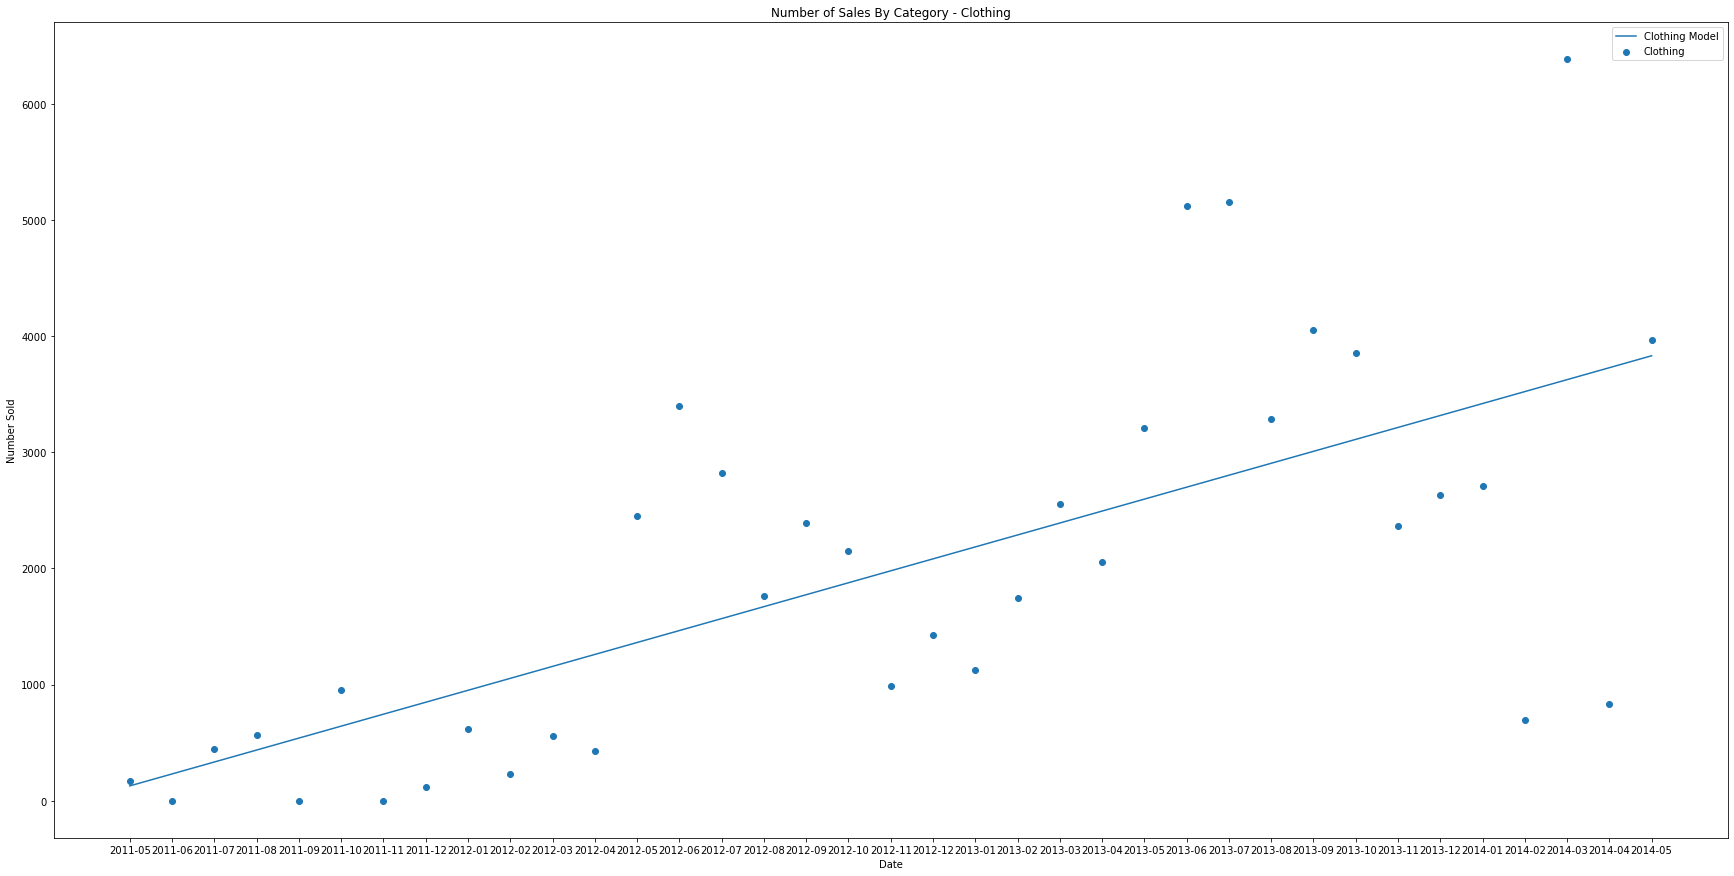

In [374]:
## Linear regression using numpy for clothing

lm_fit = np.polyfit(lm, lm_merged_df['Clothing'], deg=1)
lm_fit_function = np.poly1d(lm_fit)
plt.plot(lm_merged_df['Month'], lm_fit_function(lm), label='Clothing Model')
plt.scatter(lm_merged_df['Month'], lm_merged_df['Clothing'], label='Clothing')

plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Number of Sales By Category - Clothing')
plt.legend(loc='best')
plt.show()

In [386]:
## Get predictions for each category, append predictions to data frame

for x in range(1, 24):
    lm = np.arange(lm_merged_df['Month'].size)
    lm_fit = np.polyfit(lm, lm_merged_df['Bikes'], deg=1)
    lm_fit_function = np.poly1d(lm_fit)
    bikes_prediction = lm_fit_function(lm_merged_df['Month'].size + x)
    lm_fit = np.polyfit(lm, lm_merged_df['Others'], deg=1)
    lm_fit_function = np.poly1d(lm_fit)
    others_prediction = lm_fit_function(lm_merged_df['Month'].size + x)
    lm_fit = np.polyfit(lm, lm_merged_df['Accessories'], deg=1)
    lm_fit_function = np.poly1d(lm_fit)
    accessories_prediction = lm_fit_function(lm_merged_df['Month'].size + x)
    lm_fit = np.polyfit(lm, lm_merged_df['Clothing'], deg=1)
    lm_fit_function = np.poly1d(lm_fit)
    clothing_prediction = lm_fit_function(lm_merged_df['Month'].size + x)
    lm_fit = np.polyfit(lm, lm_merged_df['Components'], deg=1)
    lm_fit_function = np.poly1d(lm_fit)
    components_prediction = lm_fit_function(lm_merged_df['Month'].size + x)
    months = lm_merged_df['Month'].size
    prediction_date = (pandas.to_datetime(lm_merged_df.Month[0]) + pandas.DateOffset(months=months)).strftime('%Y-%m')

    to_append = [prediction_date, bikes_prediction, others_prediction, accessories_prediction, components_prediction, clothing_prediction, months]
    a_series = pandas.Series(to_append, index = lm_merged_df.columns)
    lm_merged_df = lm_merged_df.append(a_series, ignore_index=True)

lm_merged_df[['Month', 'Bikes', 'Accessories', 'Components', 'Clothing']]

,Month,Bikes,Accessories,Components,Clothing
0,2011-05,460.000000,84.000000,114.000000,167.000000
1,2011-06,141.000000,0.000000,0.000000,0.000000
2,2011-07,1283.000000,178.000000,299.000000,449.000000
3,2011-08,1681.000000,257.000000,400.000000,566.000000
4,2011-09,157.000000,0.000000,0.000000,0.000000
5,2011-10,3187.000000,484.000000,761.000000,950.000000
6,2011-11,230.000000,0.000000,0.000000,0.000000
7,2011-12,824.000000,29.000000,73.000000,114.000000
8,2012-01,2807.000000,216.000000,324.000000,620.000000
9,2012-02,947.000000,88.000000,173.000000,234.000000


In [378]:
## Get current inventory requirements for comparison

inventory_needs = product_merged_df[['Category', 'SafetyStockLevel', 'ReorderPoint']].groupby(pandas.Grouper(key='Category')).sum().unstack().unstack()
inventory_needs

Category,Components,Accessories,Clothing,Bikes
SafetyStockLevel,67000,5076,140,9700
ReorderPoint,50250,3807,105,7275


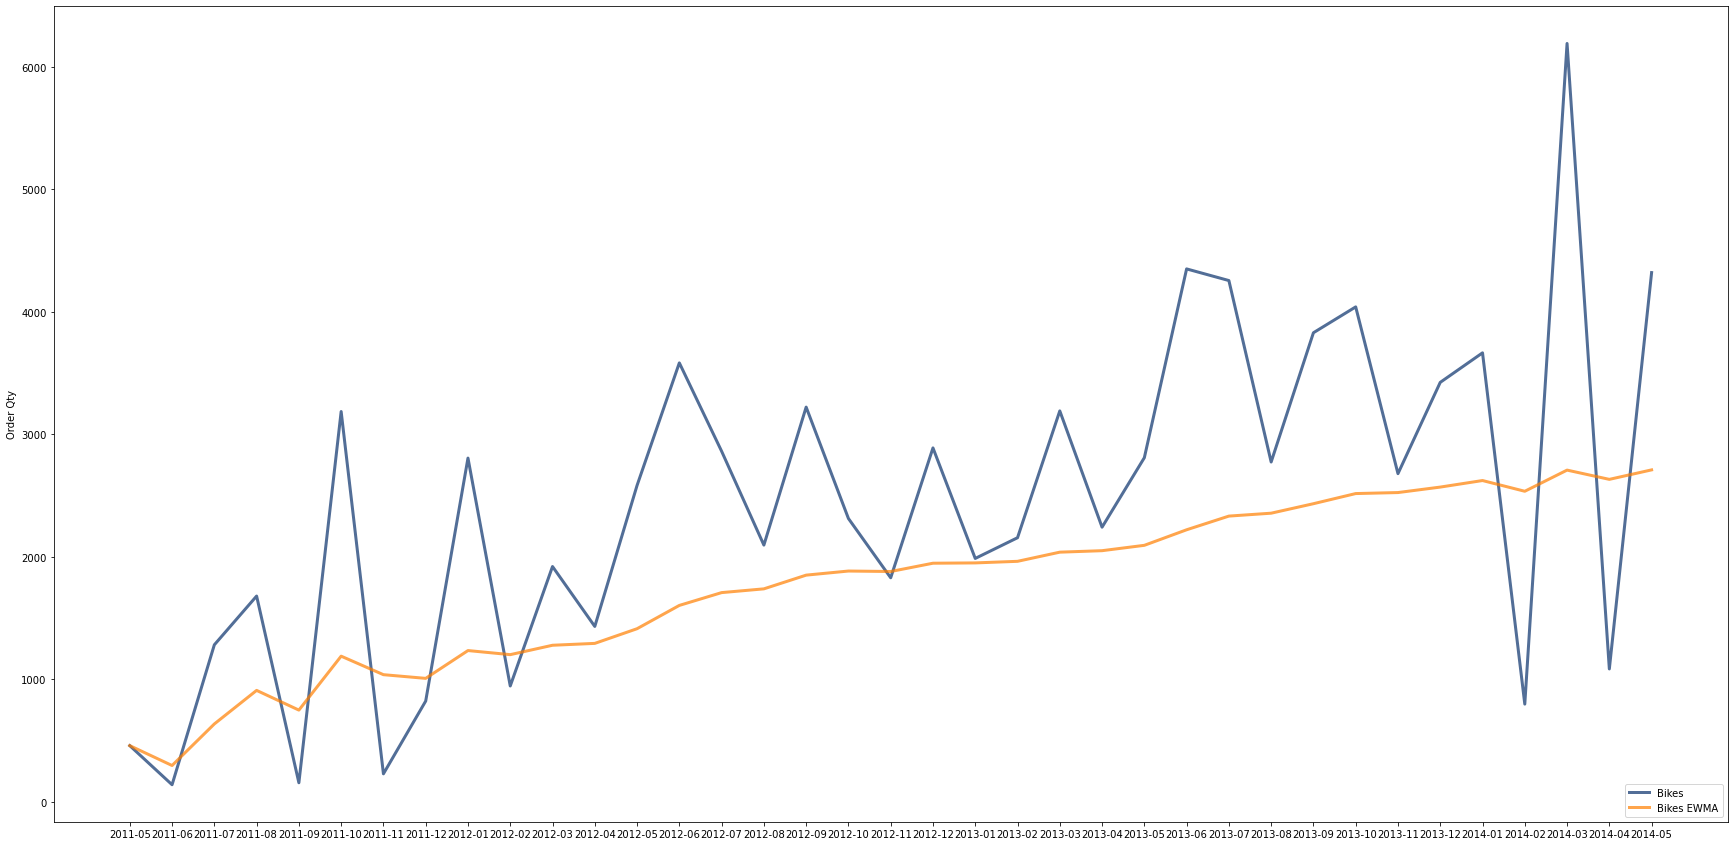

In [397]:
## EWMA analysis

reindexed = lm_merged_df.set_index(lm_merged_df['Month'])
thinkplot.Plot(reindexed['Bikes'], label='Bikes')
roll_mean = reindexed['Bikes'].ewm(30).mean()
thinkplot.Plot(roll_mean, label='Bikes EWMA', color='#ff7f00')
thinkplot.Config(ylabel='Order Qty')